In [1]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [2]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [4]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [5]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [6]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
385,84_flipped,2017.11.22,1800,44.60 s.tifheightmap.mat,21.427335,2675,23258.006678,0.921300,1,0.422992,8.694582,[[2.67500000e+03 1.34857000e+05 8.05168900e+06...,-0.940939,291.279221,[[ 295.92398288 -268.25541305]\r\n [-268.25541...,0,1,5.050505,3
241,134_flipped,2017.11.23,1800,27.00 s.tifheightmap.mat,9.930319,2326,15417.458795,0.403827,1,0.769180,6.628314,[[2.32600000e+03 6.10880000e+04 2.02309000e+06...,-0.277298,191.396970,[[209.41170118 -9.10298957]\r\n [ -9.10298957...,0,1,3.179472,4
266,157_flipped,2017.11.23,3600,10.60 s.tifheightmap.mat,9.043373,1819,7173.507255,0.858150,1,0.434959,3.943654,[[1.81900000e+03 4.83140000e+04 2.00868200e+06...,1.163312,238.267027,[[171.02166098 120.83480191]\r\n [120.83480191...,2,1,2.458774,2
79,79,2017.11.22,1800,19.60 s.tifheightmap.mat,18.741329,2120,16006.167836,0.973050,1,0.682770,7.550079,[[2.12000000e+03 1.17829000e+05 8.26033700e+06...,1.545162,257.053824,[[ 43.45564614 19.59714044]\r\n [ 19.59714044...,0,1,4.319407,2
350,52_flipped,2017.11.17,7200,1.90 s.tifheightmap.mat,7.665951,1717,6732.873700,0.948445,1,0.757055,3.921301,[[1.71700000e+03 7.67380000e+04 4.19110800e+06...,-1.495170,197.396970,[[ 47.06751865 -30.20988715]\r\n [-30.20988715...,2,1,2.254912,2


### Downsample to balanced classes

In [7]:
ds_count = min(df.groupby('date').size())
ds_flow = df.groupby('date').size().idxmin()

samples = pd.concat([df[df['date']==i].sample(n=ds_count) 
                     for i in df.date.unique()],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('date').size())

date
2017.11.09    44
2017.11.17    44
2017.11.22    44
2017.11.23    44
dtype: int64


### Drop columns which we aren't using as features

In [8]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks','cluster']).as_matrix()

In [9]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical  features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Ignore this block

In [10]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

### Split data into balanced test and training sets

In [27]:
x_test = pd.concat([df[df['date']==i].sample(n=10) for i in df.date.unique()],ignore_index=True)
y_test = x_test['date'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['date'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(136, 11)
(40, 11)


## Run Logistic Regression

In [28]:
batch_size = 16
nb_classes = 4
nb_epoch = 30

lmda = 0.001

In [29]:
input_dim = x_train.shape[1]

In [30]:
y_train[y_train == '2017.11.09'] = 0
y_train[y_train == '2017.11.17'] = 1
y_train[y_train == '2017.11.22'] = 2
y_train[y_train == '2017.11.23'] = 3

y_test[y_test == '2017.11.09'] = 0
y_test[y_test == '2017.11.17'] = 1
y_test[y_test == '2017.11.22'] = 2
y_test[y_test == '2017.11.23'] = 3

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [31]:
def build_logistic_model(input_dim, output_dim, lmda):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))
    
    return model

def compile_model(input_dim, output_dim, lmda, optimizer):
    model = build_logistic_model(input_dim,output_dim,lmda)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
model = None
model = build_logistic_model(input_dim, nb_classes,lmda)

In [34]:
y_train.shape

(136, 4)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [36]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 136 samples, validate on 40 samples
Epoch 1/30
136/136 [==============================] - 3s 20ms/step - loss: 2.0924 - acc: 0.2721 - val_loss: 2.2381 - val_acc: 0.3000
Epoch 2/30
136/136 [==============================] - 0s 456us/step - loss: 2.0324 - acc: 0.2721 - val_loss: 2.1776 - val_acc: 0.3000
Epoch 3/30
136/136 [==============================] - 0s 466us/step - loss: 1.9723 - acc: 0.2721 - val_loss: 2.1115 - val_acc: 0.3000
Epoch 4/30
136/136 [==============================] - 0s 434us/step - loss: 1.9106 - acc: 0.2868 - val_loss: 2.0583 - val_acc: 0.3000
Epoch 5/30
136/136 [==============================] - 0s 272us/step - loss: 1.8585 - acc: 0.2721 - val_loss: 2.0074 - val_acc: 0.3000
Epoch 6/30
136/136 [==============================] - 0s 265us/step - loss: 1.8107 - acc: 0.2721 - val_loss: 1.9600 - val_acc: 0.3000
Epoch 7/30
136/136 [==============================] - 0s 331us/step - loss: 1.7676 - acc: 0.2721 - val_loss: 1.9141 - val_acc: 0.3000
Epoch 8/30
136/136

In [37]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.5380619287490844
Test accuracy: 0.3


## Confusion Matrix

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

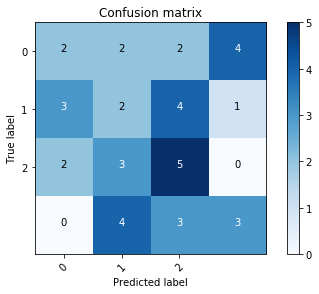

In [39]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## LR With Cross Validation

In [44]:
batch_size = 8
nb_classes = 4
lmda = 0.01

nb_epoch = 10

In [45]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [46]:
n_folds = 10

labels = df['date'].values
data = x

labels[labels == '2017.11.09'] = 0
labels[labels == '2017.11.17'] = 1
labels[labels == '2017.11.22'] = 2
labels[labels == '2017.11.23'] = 3

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['date'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes, lmda)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 156 samples, validate on 20 samples
Epoch 1/10
156/156 [==============================] - 0s 2ms/step - loss: 1.9378 - acc: 0.3013 - val_loss: 1.9008 - val_acc: 0.3500
Epoch 2/10
156/156 [==============================] - 0s 782us/step - loss: 1.8530 - acc: 0.2949 - val_loss: 1.8246 - val_acc: 0.3500
Epoch 3/10
156/156 [==============================] - 0s 775us/step - loss: 1.7780 - acc: 0.3013 - val_loss: 1.7594 - val_acc: 0.3000
Epoch 4/10
156/156 [==============================] - 0s 801us/step - loss: 1.7138 - acc: 0.3141 - val_loss: 1.7056 - val_acc: 0.3000
Epoch 5/10
156/156 [==============================] - 0s 775us/step - loss: 1.6609 - acc: 0.3269 - val_loss: 1.6560 - val_acc: 0.3500
Epoch 6/10
156/156 [==============================] - 0s 756us/step - loss: 1.6097 - acc: 0.3269 - val_loss: 1.6186 - val_acc: 0.4000
Epoch 7/10
156/156 [==============================] - 0s 653us/step - loss: 1.5674 - acc: 0.3141 - val_loss: 1.5883 - val_acc: 0.4000

160/160 [==============================] - 0s 556us/step - loss: 1.5198 - acc: 0.2438 - val_loss: 1.7285 - val_acc: 0.0625
Epoch 10/10
160/160 [==============================] - 0s 462us/step - loss: 1.5001 - acc: 0.2750 - val_loss: 1.7093 - val_acc: 0.0625
Running Fold 7 / 10
Train on 160 samples, validate on 16 samples
Epoch 1/10
160/160 [==============================] - 0s 2ms/step - loss: 1.8905 - acc: 0.1937 - val_loss: 1.5990 - val_acc: 0.4375
Epoch 2/10
160/160 [==============================] - 0s 525us/step - loss: 1.8186 - acc: 0.2000 - val_loss: 1.5886 - val_acc: 0.4375
Epoch 3/10
160/160 [==============================] - 0s 518us/step - loss: 1.7573 - acc: 0.2062 - val_loss: 1.5797 - val_acc: 0.3750
Epoch 4/10
160/160 [==============================] - 0s 437us/step - loss: 1.7048 - acc: 0.2062 - val_loss: 1.5711 - val_acc: 0.3750
Epoch 5/10
160/160 [==============================] - 0s 475us/step - loss: 1.6618 - acc: 0.2125 - val_loss: 1.5628 - val_acc: 0.3125
Epoch 6/1

In [47]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.2487499989569187


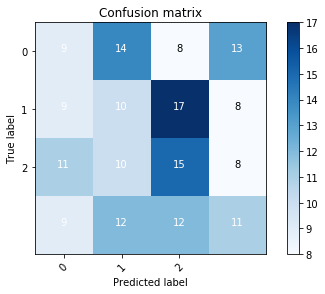

In [48]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## Grid Search on Hyper-parameters

Note: Test dataset size is wrong?

Also: This takes a while!

In [49]:
model = KerasClassifier(build_fn=compile_model,input_dim=input_dim, output_dim=nb_classes, optimizer='sgd')

param_grid = dict(epochs=[10,20,30], batch_size=[4,8,16,32], lmda=[0.001,0.005,0.01,0.05,0.1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
grid_result = grid.fit(data, one_hot)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
158/158 [==============================] - 0s 3ms/step - loss: 12.2483 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 917us/step - loss: 12.2483 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 936us/step - loss: 12.2483 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 968us/step - loss: 12.2482 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2482 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2482 - acc: 0.2405
Epoch 7/10
158/158 [==============================] - 0s 892us/step - loss: 12.2482 - acc: 0.2405
Epoch 8/10
158/158 [==============================] - 0s 905us/step - loss: 12.2482 - acc: 0.2405
Epoch 9/10
158/158 [==============================] - 0s 930us/step - loss: 12.2482 - ac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


158/158 [==============================] - 1s 3ms/step - loss: 12.3501 - acc: 0.2342
Epoch 2/10
158/158 [==============================] - 0s 968us/step - loss: 12.3501 - acc: 0.2342
Epoch 3/10
158/158 [==============================] - 0s 987us/step - loss: 12.3501 - acc: 0.2342
Epoch 4/10
158/158 [==============================] - 0s 993us/step - loss: 12.3501 - acc: 0.2342
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3501 - acc: 0.2342
Epoch 6/10
158/158 [==============================] - 0s 898us/step - loss: 12.3501 - acc: 0.2342
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3501 - acc: 0.2342
Epoch 8/10
158/158 [==============================] - 0s 892us/step - loss: 12.3501 - acc: 0.2342
Epoch 9/10
158/158 [==============================] - 0s 911us/step - loss: 12.3500 - acc: 0.2342
Epoch 10/10
158/158 [==============================] - 0s 342us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   

159/159 [==============================] - 0s 1ms/step - loss: 12.0700 - acc: 0.2516
Epoch 10/10
159/159 [==============================] - 0s 421us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   2.1s
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
159/159 [==============================] - 1s 3ms/step - loss: 11.6628 - acc: 0.2767
Epoch 2/10
159/159 [==============================] - 0s 899us/step - loss: 11.6628 - acc: 0.2767
Epoch 3/10
159/159 [==============================] - 0s 930us/step - loss: 11.6628 - acc: 0.2767
Epoch 4/10
159/159 [==============================] - 0s 918us/step - loss: 11.6628 - acc: 0.2767
Epoch 5/10
159/159 [==============================] - 0s 987us/step - loss: 11.6628 - acc: 0.2767
Epoch 6/10
159/159 [==============================] - 0s 968us/step - loss: 11.6628 - acc: 0.2767
Epoch 7/10
159/159 [==============================] - 0s 899us/step - loss: 11.6628 - acc: 0.2767
Epoch 8/10
159/159 [

158/158 [==============================] - 0s 854us/step - loss: 12.1704 - acc: 0.2468
Epoch 5/10
158/158 [==============================] - 0s 943us/step - loss: 12.1702 - acc: 0.2468
Epoch 6/10
158/158 [==============================] - 0s 879us/step - loss: 12.1699 - acc: 0.24680s - loss: 12.3708 - acc: 0.23
Epoch 7/10
158/158 [==============================] - 0s 955us/step - loss: 12.1697 - acc: 0.2468
Epoch 8/10
158/158 [==============================] - 0s 886us/step - loss: 12.1694 - acc: 0.2468
Epoch 9/10
158/158 [==============================] - 0s 905us/step - loss: 12.1692 - acc: 0.2468
Epoch 10/10
158/158 [==============================] - 0s 424us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.005, total=   2.2s
[CV] batch_size=4, epochs=10, lmda=0.005 .............................
Epoch 1/10
158/158 [==============================] - 1s 4ms/step - loss: 12.1671 - acc: 0.2468
Epoch 2/10
158/158 [==============================] - 0s 867us/step - loss: 12.1669 - 

Epoch 1/10
158/158 [==============================] - 1s 5ms/step - loss: 11.7970 - acc: 0.2722
Epoch 2/10
158/158 [==============================] - 0s 1ms/step - loss: 11.7960 - acc: 0.2722
Epoch 3/10
158/158 [==============================] - 0s 955us/step - loss: 11.7950 - acc: 0.2722
Epoch 4/10
158/158 [==============================] - 0s 968us/step - loss: 11.7940 - acc: 0.2722
Epoch 5/10
158/158 [==============================] - 0s 898us/step - loss: 11.7930 - acc: 0.2722
Epoch 6/10
158/158 [==============================] - 0s 974us/step - loss: 11.7920 - acc: 0.2722
Epoch 7/10
158/158 [==============================] - 0s 980us/step - loss: 11.7910 - acc: 0.2722
Epoch 8/10
158/158 [==============================] - 0s 930us/step - loss: 11.7901 - acc: 0.2722
Epoch 9/10
158/158 [==============================] - 0s 898us/step - loss: 11.7892 - acc: 0.2722
Epoch 10/10
158/158 [==============================] - 0s 405us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.

Epoch 10/10
159/159 [==============================] - 0s 484us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   3.9s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
159/159 [==============================] - 1s 6ms/step - loss: 12.3094 - acc: 0.2390
Epoch 2/10
159/159 [==============================] - 0s 974us/step - loss: 12.3088 - acc: 0.2390
Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 12.3081 - acc: 0.2390
Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 12.3074 - acc: 0.2390
Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 12.3067 - acc: 0.2390
Epoch 6/10
159/159 [==============================] - 0s 949us/step - loss: 12.3061 - acc: 0.2390
Epoch 7/10
159/159 [==============================] - 0s 962us/step - loss: 12.3055 - acc: 0.2390
Epoch 8/10
159/159 [==============================] - 0s 962us/step - loss: 12.3048 - acc: 0.2390
Epoch 9/10
15

158/158 [==============================] - 0s 968us/step - loss: 12.3366 - acc: 0.2468
Epoch 6/10
158/158 [==============================] - 0s 949us/step - loss: 12.3214 - acc: 0.2468
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3075 - acc: 0.2468
Epoch 8/10
158/158 [==============================] - 0s 968us/step - loss: 12.2945 - acc: 0.2468
Epoch 9/10
158/158 [==============================] - 0s 961us/step - loss: 12.2826 - acc: 0.2468
Epoch 10/10
158/158 [==============================] - 0s 544us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.05, total=   2.9s
[CV] batch_size=4, epochs=10, lmda=0.05 ..............................
Epoch 1/10
158/158 [==============================] - 1s 7ms/step - loss: 12.5193 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 974us/step - loss: 12.4979 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 999us/step - loss: 12.4782 - acc: 0.2405
Epoch 4/10
158/158 [

Epoch 1/10
158/158 [==============================] - 1s 7ms/step - loss: 12.2510 - acc: 0.2722
Epoch 2/10
158/158 [==============================] - 0s 1ms/step - loss: 12.1741 - acc: 0.2722
Epoch 3/10
158/158 [==============================] - 0s 1ms/step - loss: 12.1086 - acc: 0.2722
Epoch 4/10
158/158 [==============================] - 0s 1ms/step - loss: 12.0528 - acc: 0.2722
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 12.0052 - acc: 0.2722
Epoch 6/10
158/158 [==============================] - 0s 930us/step - loss: 11.9647 - acc: 0.2722
Epoch 7/10
158/158 [==============================] - 0s 949us/step - loss: 11.9302 - acc: 0.2722
Epoch 8/10
158/158 [==============================] - 0s 936us/step - loss: 11.9008 - acc: 0.2722
Epoch 9/10
158/158 [==============================] - 0s 1ms/step - loss: 11.8758 - acc: 0.2722
Epoch 10/10
158/158 [==============================] - 0s 455us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, tota

159/159 [==============================] - 0s 943us/step - loss: 12.4297 - acc: 0.2390
Epoch 10/10
159/159 [==============================] - 0s 515us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   3.3s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
159/159 [==============================] - 1s 8ms/step - loss: 12.2858 - acc: 0.2642
Epoch 2/10
159/159 [==============================] - 0s 968us/step - loss: 12.2228 - acc: 0.2642
Epoch 3/10
159/159 [==============================] - 0s 911us/step - loss: 12.1692 - acc: 0.2642
Epoch 4/10
159/159 [==============================] - 0s 930us/step - loss: 12.1235 - acc: 0.2642
Epoch 5/10
159/159 [==============================] - 0s 968us/step - loss: 12.0846 - acc: 0.2642
Epoch 6/10
159/159 [==============================] - 0s 911us/step - loss: 12.0514 - acc: 0.2642
Epoch 7/10
159/159 [==============================] - 0s 937us/step - loss: 12.0232 - acc: 0.2642
Epoch 8/10
159/159

158/158 [==============================] - 0s 917us/step - loss: 12.1452 - acc: 0.2468
Epoch 10/20
158/158 [==============================] - 0s 917us/step - loss: 12.1452 - acc: 0.2468
Epoch 11/20
158/158 [==============================] - 0s 980us/step - loss: 12.1452 - acc: 0.2468
Epoch 12/20
158/158 [==============================] - 0s 963us/step - loss: 12.1452 - acc: 0.2468
Epoch 13/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1452 - acc: 0.2468
Epoch 14/20
158/158 [==============================] - 0s 981us/step - loss: 12.1451 - acc: 0.2468
Epoch 15/20
158/158 [==============================] - 0s 905us/step - loss: 12.1451 - acc: 0.2468
Epoch 16/20
158/158 [==============================] - 0s 924us/step - loss: 12.1451 - acc: 0.2468
Epoch 17/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1451 - acc: 0.2468
Epoch 18/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1451 - acc: 0.2468
Epoch 19/20
158/158 [=======

Epoch 2/20
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 3/20
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 4/20
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 5/20
159/159 [==============================] - 0s 999us/step - loss: 12.0693 - acc: 0.2516
Epoch 6/20
159/159 [==============================] - 0s 949us/step - loss: 12.0693 - acc: 0.2516
Epoch 7/20
159/159 [==============================] - 0s 949us/step - loss: 12.0693 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 955us/step - loss: 12.0693 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 930us/step - loss: 12.0693 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 930us/step - loss: 12.0693 - acc: 0.2516
Epoch 11/20
159/159 [==============================] - 0s 874us/step - loss: 12.0693 - acc: 0.2516
Epoch 12/20
159/159 [===

159/159 [==============================] - 0s 974us/step - loss: 11.9664 - acc: 0.2579
Epoch 19/20
159/159 [==============================] - 0s 987us/step - loss: 11.9664 - acc: 0.2579
Epoch 20/20
159/159 [==============================] - 0s 484us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=   5.2s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/20
158/158 [==============================] - 2s 10ms/step - loss: 12.3689 - acc: 0.2342
Epoch 2/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3687 - acc: 0.2342
Epoch 3/20
158/158 [==============================] - 0s 949us/step - loss: 12.3685 - acc: 0.2342
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3683 - acc: 0.2342
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3681 - acc: 0.2342
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3679 - acc: 0.2342
Epoch 7/20
158/158 [====

158/158 [==============================] - 0s 893us/step - loss: 11.9585 - acc: 0.2595
Epoch 12/20
158/158 [==============================] - 0s 886us/step - loss: 11.9584 - acc: 0.2595
Epoch 13/20
158/158 [==============================] - 0s 898us/step - loss: 11.9582 - acc: 0.2595
Epoch 14/20
158/158 [==============================] - 0s 955us/step - loss: 11.9580 - acc: 0.2595
Epoch 15/20
158/158 [==============================] - 0s 867us/step - loss: 11.9578 - acc: 0.2595
Epoch 16/20
158/158 [==============================] - 0s 1ms/step - loss: 11.9576 - acc: 0.2595
Epoch 17/20
158/158 [==============================] - 0s 924us/step - loss: 11.9575 - acc: 0.2595
Epoch 18/20
158/158 [==============================] - 0s 980us/step - loss: 11.9573 - acc: 0.2595
Epoch 19/20
158/158 [==============================] - 0s 1ms/step - loss: 11.9571 - acc: 0.2595
Epoch 20/20
158/158 [==============================] - 0s 415us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.005,

159/159 [==============================] - 0s 1ms/step - loss: 12.0921 - acc: 0.2516
Epoch 5/20
159/159 [==============================] - 0s 968us/step - loss: 12.0919 - acc: 0.2516
Epoch 6/20
159/159 [==============================] - 0s 930us/step - loss: 12.0917 - acc: 0.2516
Epoch 7/20
159/159 [==============================] - 0s 1ms/step - loss: 12.0914 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 949us/step - loss: 12.0912 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 962us/step - loss: 12.0910 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 930us/step - loss: 12.0908 - acc: 0.2516
Epoch 11/20
159/159 [==============================] - 0s 1ms/step - loss: 12.0905 - acc: 0.2516
Epoch 12/20
159/159 [==============================] - 0s 918us/step - loss: 12.0903 - acc: 0.2516
Epoch 13/20
159/159 [==============================] - 0s 943us/step - loss: 12.0901 - acc: 0.2516
Epoch 14/20
159/159 [============

158/158 [==============================] - 0s 993us/step - loss: 13.5597 - acc: 0.2342
Epoch 20/20
158/158 [==============================] - 0s 455us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=   5.4s
[CV] batch_size=4, epochs=20, lmda=0.01 ..............................
Epoch 1/20
158/158 [==============================] - 2s 11ms/step - loss: 12.0985 - acc: 0.2532
Epoch 2/20
158/158 [==============================] - 0s 2ms/step - loss: 12.0976 - acc: 0.2532
Epoch 3/20
158/158 [==============================] - 0s 2ms/step - loss: 12.0966 - acc: 0.2532
Epoch 4/20
158/158 [==============================] - 0s 2ms/step - loss: 12.0957 - acc: 0.2532
Epoch 5/20
158/158 [==============================] - 0s 942us/step - loss: 12.0948 - acc: 0.2532
Epoch 6/20
158/158 [==============================] - 0s 879us/step - loss: 12.0939 - acc: 0.2532
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.0930 - acc: 0.2532
Epoch 8/20
158/158 [=====

158/158 [==============================] - 0s 1ms/step - loss: 12.1803 - acc: 0.2468
Epoch 13/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1796 - acc: 0.2468
Epoch 14/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1790 - acc: 0.2468
Epoch 15/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1783 - acc: 0.2468
Epoch 16/20
158/158 [==============================] - ETA: 0s - loss: 11.8826 - acc: 0.26 - 0s 1ms/step - loss: 12.1777 - acc: 0.2468
Epoch 17/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1771 - acc: 0.2468
Epoch 18/20
158/158 [==============================] - 0s 955us/step - loss: 12.1765 - acc: 0.2468
Epoch 19/20
158/158 [==============================] - 0s 898us/step - loss: 12.1759 - acc: 0.2468
Epoch 20/20
158/158 [==============================] - 0s 500us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=   6.7s
[CV] batch_size=4, epochs=20, lmda=0.01 ..............

159/159 [==============================] - 0s 1ms/step - loss: 12.3303 - acc: 0.2390
Epoch 6/20
159/159 [==============================] - 0s 955us/step - loss: 12.3293 - acc: 0.2390
Epoch 7/20
159/159 [==============================] - 0s 949us/step - loss: 12.3283 - acc: 0.2390
Epoch 8/20
159/159 [==============================] - 0s 981us/step - loss: 12.3273 - acc: 0.2390
Epoch 9/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3264 - acc: 0.2390
Epoch 10/20
159/159 [==============================] - 0s 993us/step - loss: 12.3254 - acc: 0.2390
Epoch 11/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3245 - acc: 0.2390
Epoch 12/20
159/159 [==============================] - 0s 993us/step - loss: 12.3235 - acc: 0.2390
Epoch 13/20
159/159 [==============================] - 0s 993us/step - loss: 12.3226 - acc: 0.2390
Epoch 14/20
159/159 [==============================] - 0s 987us/step - loss: 12.3217 - acc: 0.2390
Epoch 15/20
159/159 [===========

158/158 [==============================] - 0s 474us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=   6.0s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
158/158 [==============================] - 2s 13ms/step - loss: 12.4270 - acc: 0.2468
Epoch 2/20
158/158 [==============================] - 0s 1ms/step - loss: 12.4048 - acc: 0.2468
Epoch 3/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3844 - acc: 0.2468
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3656 - acc: 0.2468
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3482 - acc: 0.2468
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3322 - acc: 0.2468
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3174 - acc: 0.2468
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3037 - acc: 0.2468
Epoch 9/20
158/158 [============

158/158 [==============================] - 0s 1ms/step - loss: 12.3305 - acc: 0.2405
Epoch 15/20
158/158 [==============================] - 0s 942us/step - loss: 12.3237 - acc: 0.2405
Epoch 16/20
158/158 [==============================] - 0s 987us/step - loss: 12.3174 - acc: 0.2405
Epoch 17/20
158/158 [==============================] - 0s 987us/step - loss: 12.3116 - acc: 0.2405
Epoch 18/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3062 - acc: 0.2405
Epoch 19/20
158/158 [==============================] - 0s 936us/step - loss: 12.3012 - acc: 0.2405
Epoch 20/20
158/158 [==============================] - 0s 512us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=   6.0s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
159/159 [==============================] - 2s 13ms/step - loss: 12.3898 - acc: 0.2516
Epoch 2/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3647 - acc: 0.2516
Epoch 3/20
159/159

159/159 [==============================] - 0s 937us/step - loss: 12.2270 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 1ms/step - loss: 12.2144 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 918us/step - loss: 12.2028 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 962us/step - loss: 12.1921 - acc: 0.2516
Epoch 11/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1822 - acc: 0.2516
Epoch 12/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1730 - acc: 0.2516
Epoch 13/20
159/159 [==============================] - 0s 955us/step - loss: 12.1646 - acc: 0.2516
Epoch 14/20
159/159 [==============================] - 0s 937us/step - loss: 12.1568 - acc: 0.2516
Epoch 15/20
159/159 [==============================] - 0s 937us/step - loss: 12.1496 - acc: 0.2516
Epoch 16/20
159/159 [==============================] - 0s 918us/step - loss: 12.1429 - acc: 0.2516
Epoch 17/20
159/159 [=========

Epoch 1/20
158/158 [==============================] - 2s 15ms/step - loss: 12.5705 - acc: 0.2532
Epoch 2/20
158/158 [==============================] - 0s 1ms/step - loss: 12.4916 - acc: 0.2532
Epoch 3/20
158/158 [==============================] - 0s 1ms/step - loss: 12.4244 - acc: 0.2532
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3672 - acc: 0.2532
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3184 - acc: 0.2532
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2768 - acc: 0.2532
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2414 - acc: 0.2532
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2112 - acc: 0.2532
Epoch 9/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1855 - acc: 0.2532
Epoch 10/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1636 - acc: 0.2532
Epoch 11/20
158/158 [=================

159/159 [==============================] - 0s 981us/step - loss: 12.2017 - acc: 0.2453
Epoch 18/20
159/159 [==============================] - 0s 974us/step - loss: 12.1962 - acc: 0.2453
Epoch 19/20
159/159 [==============================] - 0s 937us/step - loss: 12.1915 - acc: 0.2453
Epoch 20/20
159/159 [==============================] - 0s 484us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=   6.4s
[CV] batch_size=4, epochs=20, lmda=0.1 ...............................
Epoch 1/20
159/159 [==============================] - 2s 14ms/step - loss: 12.5653 - acc: 0.2516
Epoch 2/20
159/159 [==============================] - 0s 955us/step - loss: 12.4910 - acc: 0.2516
Epoch 3/20
159/159 [==============================] - 0s 1ms/step - loss: 12.4277 - acc: 0.2516
Epoch 4/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3738 - acc: 0.2516
Epoch 5/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3278 - acc: 0.2516
Epoch 6/20
159/159 [=

Epoch 10/30
158/158 [==============================] - 0s 955us/step - loss: 12.3504 - acc: 0.2342
Epoch 11/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3504 - acc: 0.2342
Epoch 12/30
158/158 [==============================] - 0s 936us/step - loss: 12.3504 - acc: 0.2342
Epoch 13/30
158/158 [==============================] - 0s 961us/step - loss: 12.3504 - acc: 0.2342
Epoch 14/30
158/158 [==============================] - 0s 943us/step - loss: 12.3504 - acc: 0.2342
Epoch 15/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3504 - acc: 0.2342
Epoch 16/30
158/158 [==============================] - 0s 999us/step - loss: 12.3504 - acc: 0.2342
Epoch 17/30
158/158 [==============================] - 0s 936us/step - loss: 12.3503 - acc: 0.2342
Epoch 18/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3503 - acc: 0.2342
Epoch 19/30
158/158 [==============================] - 0s 999us/step - loss: 12.3503 - acc: 0.2342
Epoch 20/30
158/

158/158 [==============================] - 0s 1ms/step - loss: 12.1471 - acc: 0.2468
Epoch 29/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1471 - acc: 0.2468
Epoch 30/30
158/158 [==============================] - 0s 797us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.001, total=   9.0s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
158/158 [==============================] - 2s 15ms/step - loss: 11.3300 - acc: 0.2975
Epoch 2/30
158/158 [==============================] - 0s 2ms/step - loss: 11.3299 - acc: 0.2975
Epoch 3/30
158/158 [==============================] - 0s 2ms/step - loss: 11.3299 - acc: 0.2975
Epoch 4/30
158/158 [==============================] - 0s 1ms/step - loss: 11.3299 - acc: 0.2975
Epoch 5/30
158/158 [==============================] - 0s 1ms/step - loss: 11.3299 - acc: 0.2975
Epoch 6/30
158/158 [==============================] - 0s 1ms/step - loss: 11.3299 - acc: 0.2975
Epoch 7/30
158/158 [==========

158/158 [==============================] - 0s 879us/step - loss: 12.1452 - acc: 0.2468
Epoch 15/30
158/158 [==============================] - 0s 955us/step - loss: 12.1452 - acc: 0.2468
Epoch 16/30
158/158 [==============================] - 0s 943us/step - loss: 12.1452 - acc: 0.2468
Epoch 17/30
158/158 [==============================] - 0s 886us/step - loss: 12.1452 - acc: 0.2468
Epoch 18/30
158/158 [==============================] - 0s 974us/step - loss: 12.1451 - acc: 0.2468
Epoch 19/30
158/158 [==============================] - 0s 905us/step - loss: 12.1451 - acc: 0.2468
Epoch 20/30
158/158 [==============================] - 0s 968us/step - loss: 12.1451 - acc: 0.2468
Epoch 21/30
158/158 [==============================] - 0s 905us/step - loss: 12.1451 - acc: 0.2468
Epoch 22/30
158/158 [==============================] - 0s 936us/step - loss: 12.1451 - acc: 0.2468
Epoch 23/30
158/158 [==============================] - 0s 955us/step - loss: 12.1451 - acc: 0.2468
Epoch 24/30
158/158 [=

Epoch 1/30
159/159 [==============================] - 2s 16ms/step - loss: 12.0694 - acc: 0.2516
Epoch 2/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 3/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 4/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 5/30
159/159 [==============================] - 0s 936us/step - loss: 12.0694 - acc: 0.2516
Epoch 6/30
159/159 [==============================] - 0s 974us/step - loss: 12.0694 - acc: 0.2516
Epoch 7/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0694 - acc: 0.2516
Epoch 8/30
159/159 [==============================] - 0s 949us/step - loss: 12.0693 - acc: 0.2516
Epoch 9/30
159/159 [==============================] - 0s 955us/step - loss: 12.0693 - acc: 0.2516
Epoch 10/30
159/159 [==============================] - 0s 993us/step - loss: 12.0693 - acc: 0.2516
Epoch 11/30
159/159 [=======

158/158 [==============================] - 0s 974us/step - loss: 11.8623 - acc: 0.2658
Epoch 20/30
158/158 [==============================] - 0s 987us/step - loss: 11.8621 - acc: 0.2658
Epoch 21/30
158/158 [==============================] - 0s 987us/step - loss: 11.8619 - acc: 0.2658
Epoch 22/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8616 - acc: 0.2658
Epoch 23/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8614 - acc: 0.2658
Epoch 24/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8612 - acc: 0.2658
Epoch 25/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8610 - acc: 0.2658
Epoch 26/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8608 - acc: 0.2658
Epoch 27/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8605 - acc: 0.2658
Epoch 28/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8603 - acc: 0.2658
Epoch 29/30
158/158 [===============

158/158 [==============================] - 0s 987us/step - loss: 11.9612 - acc: 0.2595
Epoch 6/30
158/158 [==============================] - 0s 993us/step - loss: 11.9610 - acc: 0.2595
Epoch 7/30
158/158 [==============================] - 0s 993us/step - loss: 11.9608 - acc: 0.2595
Epoch 8/30
158/158 [==============================] - 0s 1ms/step - loss: 11.9606 - acc: 0.2595
Epoch 9/30
158/158 [==============================] - 0s 1ms/step - loss: 11.9604 - acc: 0.2595
Epoch 10/30
158/158 [==============================] - 0s 993us/step - loss: 11.9602 - acc: 0.2595
Epoch 11/30
158/158 [==============================] - 0s 955us/step - loss: 11.9600 - acc: 0.2595
Epoch 12/30
158/158 [==============================] - 0s 980us/step - loss: 11.9598 - acc: 0.2595
Epoch 13/30
158/158 [==============================] - 0s 1ms/step - loss: 11.9596 - acc: 0.2595
Epoch 14/30
158/158 [==============================] - 0s 1ms/step - loss: 11.9594 - acc: 0.2595
Epoch 15/30
158/158 [=============

158/158 [==============================] - 0s 999us/step - loss: 4670.4444 - acc: 0.2405
Epoch 24/30
158/158 [==============================] - 0s 974us/step - loss: 4633.3268 - acc: 0.2405
Epoch 25/30
158/158 [==============================] - 0s 993us/step - loss: 4596.5050 - acc: 0.2405
Epoch 26/30
158/158 [==============================] - 0s 1ms/step - loss: 4559.9758 - acc: 0.2405
Epoch 27/30
158/158 [==============================] - 0s 1ms/step - loss: 4523.7367 - acc: 0.2405
Epoch 28/30
158/158 [==============================] - 0s 1ms/step - loss: 4487.7875 - acc: 0.2405
Epoch 29/30
158/158 [==============================] - 0s 1ms/step - loss: 4452.1243 - acc: 0.2405
Epoch 30/30
158/158 [==============================] - 0s 557us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.005, total=   9.2s
[CV] batch_size=4, epochs=30, lmda=0.005 .............................
Epoch 1/30
159/159 [==============================] - 3s 17ms/step - loss: 48.5715 - acc: 0.2264
Epoch

159/159 [==============================] - 0s 1ms/step - loss: 12.2907 - acc: 0.2390
Epoch 10/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2905 - acc: 0.2390
Epoch 11/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2903 - acc: 0.2390
Epoch 12/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2901 - acc: 0.2390
Epoch 13/30
159/159 [==============================] - 0s 981us/step - loss: 12.2899 - acc: 0.2390
Epoch 14/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2897 - acc: 0.2390
Epoch 15/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2895 - acc: 0.2390
Epoch 16/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2893 - acc: 0.2390
Epoch 17/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2891 - acc: 0.2390
Epoch 18/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2890 - acc: 0.2390
Epoch 19/30
159/159 [===================

158/158 [==============================] - 0s 1ms/step - loss: 11.8710 - acc: 0.2658
Epoch 28/30
158/158 [==============================] - 0s 980us/step - loss: 11.8704 - acc: 0.2658
Epoch 29/30
158/158 [==============================] - 0s 980us/step - loss: 11.8698 - acc: 0.2658
Epoch 30/30
158/158 [==============================] - 0s 557us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=   8.8s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
158/158 [==============================] - 3s 19ms/step - loss: 12.4038 - acc: 0.2342
Epoch 2/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4028 - acc: 0.2342
Epoch 3/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4019 - acc: 0.2342
Epoch 4/30
158/158 [==============================] - 0s 958us/step - loss: 12.4010 - acc: 0.2342
Epoch 5/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4001 - acc: 0.2342
Epoch 6/30
158/158 [===

158/158 [==============================] - 0s 987us/step - loss: 13.6034 - acc: 0.2342
Epoch 14/30
158/158 [==============================] - 0s 2ms/step - loss: 13.5834 - acc: 0.2342
Epoch 15/30
158/158 [==============================] - 0s 1ms/step - loss: 13.5637 - acc: 0.2342
Epoch 16/30
158/158 [==============================] - 0s 1ms/step - loss: 13.5443 - acc: 0.2342
Epoch 17/30
158/158 [==============================] - 0s 1ms/step - loss: 13.5253 - acc: 0.2342
Epoch 18/30
158/158 [==============================] - 0s 2ms/step - loss: 13.5065 - acc: 0.2342: 0s - loss: 12.8088 - acc: 
Epoch 19/30
158/158 [==============================] - 0s 1ms/step - loss: 13.4881 - acc: 0.2342
Epoch 20/30
158/158 [==============================] - 0s 2ms/step - loss: 13.4699 - acc: 0.2342
Epoch 21/30
158/158 [==============================] - 0s 3ms/step - loss: 13.4520 - acc: 0.2342
Epoch 22/30
158/158 [==============================] - 0s 1ms/step - loss: 13.4344 - acc: 0.2342
Epoch 23/30


158/158 [==============================] - 0s 519us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=   8.9s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
159/159 [==============================] - 3s 18ms/step - loss: 12.0123 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0115 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0107 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0099 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0091 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0084 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0076 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0069 - acc: 0.2579
Epoch 9/30
159/159 [============

159/159 [==============================] - 0s 949us/step - loss: 12.2126 - acc: 0.2453
Epoch 18/30
159/159 [==============================] - 0s 968us/step - loss: 12.2118 - acc: 0.2453
Epoch 19/30
159/159 [==============================] - 0s 987us/step - loss: 12.2111 - acc: 0.2453
Epoch 20/30
159/159 [==============================] - 0s 937us/step - loss: 12.2104 - acc: 0.2453
Epoch 21/30
159/159 [==============================] - 0s 943us/step - loss: 12.2096 - acc: 0.2453
Epoch 22/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2089 - acc: 0.2453
Epoch 23/30
159/159 [==============================] - 0s 987us/step - loss: 12.2082 - acc: 0.2453
Epoch 24/30
159/159 [==============================] - 0s 968us/step - loss: 12.2075 - acc: 0.2453
Epoch 25/30
159/159 [==============================] - 0s 974us/step - loss: 12.2068 - acc: 0.2453
Epoch 26/30
159/159 [==============================] - 0s 981us/step - loss: 12.2062 - acc: 0.2453
Epoch 27/30
159/159 [===

158/158 [==============================] - 0s 1ms/step - loss: 12.3398 - acc: 0.2468
Epoch 3/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3244 - acc: 0.2468
Epoch 4/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3102 - acc: 0.2468
Epoch 5/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2971 - acc: 0.2468
Epoch 6/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2850 - acc: 0.2468
Epoch 7/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2738 - acc: 0.2468
Epoch 8/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2635 - acc: 0.2468
Epoch 9/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2539 - acc: 0.2468
Epoch 10/30
158/158 [==============================] - 0s 955us/step - loss: 12.2451 - acc: 0.2468
Epoch 11/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2370 - acc: 0.2468
Epoch 12/30
158/158 [==========================

158/158 [==============================] - 0s 1ms/step - loss: 12.4047 - acc: 0.2342
Epoch 22/30
158/158 [==============================] - 0s 949us/step - loss: 12.4000 - acc: 0.2342
Epoch 23/30
158/158 [==============================] - 0s 987us/step - loss: 12.3957 - acc: 0.2342
Epoch 24/30
158/158 [==============================] - 0s 943us/step - loss: 12.3917 - acc: 0.2342
Epoch 25/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3880 - acc: 0.2342
Epoch 26/30
158/158 [==============================] - 0s 987us/step - loss: 12.3846 - acc: 0.2342
Epoch 27/30
158/158 [==============================] - 0s 999us/step - loss: 12.3814 - acc: 0.2342
Epoch 28/30
158/158 [==============================] - 0s 974us/step - loss: 12.3785 - acc: 0.2342
Epoch 29/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3758 - acc: 0.2342
Epoch 30/30
158/158 [==============================] - 0s 601us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.05, t

159/159 [==============================] - 0s 1ms/step - loss: 12.3363 - acc: 0.2453
Epoch 8/30
159/159 [==============================] - 0s 1ms/step - loss: 12.3231 - acc: 0.2453
Epoch 9/30
159/159 [==============================] - 0s 1ms/step - loss: 12.3109 - acc: 0.2453
Epoch 10/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2997 - acc: 0.2453
Epoch 11/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2893 - acc: 0.2453
Epoch 12/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2797 - acc: 0.2453
Epoch 13/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2708 - acc: 0.2453
Epoch 14/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2627 - acc: 0.2453
Epoch 15/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2551 - acc: 0.2453
Epoch 16/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2482 - acc: 0.2453
Epoch 17/30
159/159 [=======================

159/159 [==============================] - 0s 981us/step - loss: 12.1012 - acc: 0.2516
Epoch 26/30
159/159 [==============================] - 0s 962us/step - loss: 12.0983 - acc: 0.2516
Epoch 27/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0956 - acc: 0.2516
Epoch 28/30
159/159 [==============================] - 0s 981us/step - loss: 12.0931 - acc: 0.2516
Epoch 29/30
159/159 [==============================] - 0s 1ms/step - loss: 12.0908 - acc: 0.2516
Epoch 30/30
159/159 [==============================] - 0s 572us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.05, total=   9.3s
[CV] batch_size=4, epochs=30, lmda=0.05 ..............................
Epoch 1/30
159/159 [==============================] - 3s 20ms/step - loss: 12.5534 - acc: 0.2390
Epoch 2/30
159/159 [==============================] - 0s 1ms/step - loss: 12.5313 - acc: 0.2390
Epoch 3/30
159/159 [==============================] - 0s 1ms/step - loss: 12.5109 - acc: 0.2390
Epoch 4/30
159/159 [=

158/158 [==============================] - 0s 1ms/step - loss: 12.1380 - acc: 0.2532
Epoch 12/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1232 - acc: 0.2532
Epoch 13/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1105 - acc: 0.2532
Epoch 14/30
158/158 [==============================] - 0s 974us/step - loss: 12.0997 - acc: 0.2532
Epoch 15/30
158/158 [==============================] - 0s 1ms/step - loss: 12.0905 - acc: 0.2532
Epoch 16/30
158/158 [==============================] - 0s 955us/step - loss: 12.0827 - acc: 0.2532
Epoch 17/30
158/158 [==============================] - 0s 980us/step - loss: 12.0760 - acc: 0.2532
Epoch 18/30
158/158 [==============================] - 0s 1ms/step - loss: 12.0703 - acc: 0.2532
Epoch 19/30
158/158 [==============================] - 0s 1ms/step - loss: 12.0655 - acc: 0.2532
Epoch 20/30
158/158 [==============================] - 0s 1ms/step - loss: 12.0613 - acc: 0.2532
Epoch 21/30
158/158 [===============

158/158 [==============================] - 0s 569us/step
[CV] ................ batch_size=4, epochs=30, lmda=0.1, total=   9.5s
[CV] batch_size=4, epochs=30, lmda=0.1 ...............................
Epoch 1/30
158/158 [==============================] - 3s 21ms/step - loss: 12.6385 - acc: 0.2468
Epoch 2/30
158/158 [==============================] - 0s 1ms/step - loss: 12.5646 - acc: 0.2468
Epoch 3/30
158/158 [==============================] - 0s 1ms/step - loss: 12.5017 - acc: 0.2468
Epoch 4/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4481 - acc: 0.2468
Epoch 5/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4025 - acc: 0.2468
Epoch 6/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3636 - acc: 0.2468
Epoch 7/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3304 - acc: 0.2468
Epoch 8/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3022 - acc: 0.2468
Epoch 9/30
158/158 [============

159/159 [==============================] - 0s 1ms/step - loss: 28.8783 - acc: 0.2516
Epoch 17/30
159/159 [==============================] - 0s 1ms/step - loss: 26.3898 - acc: 0.2516
Epoch 18/30
159/159 [==============================] - 0s 1ms/step - loss: 24.2696 - acc: 0.2516
Epoch 19/30
159/159 [==============================] - 0s 1ms/step - loss: 22.4631 - acc: 0.2516
Epoch 20/30
159/159 [==============================] - 0s 1ms/step - loss: 20.9240 - acc: 0.2516
Epoch 21/30
159/159 [==============================] - 0s 1ms/step - loss: 19.6127 - acc: 0.2516
Epoch 22/30
159/159 [==============================] - 0s 1ms/step - loss: 18.4954 - acc: 0.2516
Epoch 23/30
159/159 [==============================] - 0s 1ms/step - loss: 17.5435 - acc: 0.2516
Epoch 24/30
159/159 [==============================] - 0s 1ms/step - loss: 16.7325 - acc: 0.2516
Epoch 25/30
159/159 [==============================] - 0s 1ms/step - loss: 16.0414 - acc: 0.2516
Epoch 26/30
159/159 [=====================

159/159 [==============================] - 0s 1ms/step - loss: 12.9659 - acc: 0.2201
Epoch 3/30
159/159 [==============================] - 0s 2ms/step - loss: 12.9074 - acc: 0.2201
Epoch 4/30
159/159 [==============================] - 0s 2ms/step - loss: 12.8574 - acc: 0.2201
Epoch 5/30
159/159 [==============================] - 0s 2ms/step - loss: 12.8149 - acc: 0.2201
Epoch 6/30
159/159 [==============================] - 0s 1ms/step - loss: 12.7787 - acc: 0.2201
Epoch 7/30
159/159 [==============================] - 0s 1ms/step - loss: 12.7478 - acc: 0.2201
Epoch 8/30
159/159 [==============================] - 0s 1ms/step - loss: 12.7215 - acc: 0.2201
Epoch 9/30
159/159 [==============================] - 0s 2ms/step - loss: 12.6991 - acc: 0.2201
Epoch 10/30
159/159 [==============================] - 0s 1ms/step - loss: 12.6800 - acc: 0.2201
Epoch 11/30
159/159 [==============================] - 0s 3ms/step - loss: 12.6637 - acc: 0.2201
Epoch 12/30
159/159 [============================

158/158 [==============================] - 0s 822us/step - loss: 12.0434 - acc: 0.2532
Epoch 3/10
158/158 [==============================] - 0s 854us/step - loss: 12.0434 - acc: 0.2532
Epoch 4/10
158/158 [==============================] - 0s 620us/step - loss: 12.0434 - acc: 0.2532
Epoch 5/10
158/158 [==============================] - 0s 525us/step - loss: 12.0434 - acc: 0.2532
Epoch 6/10
158/158 [==============================] - 0s 588us/step - loss: 12.0434 - acc: 0.2532
Epoch 7/10
158/158 [==============================] - 0s 538us/step - loss: 12.0434 - acc: 0.2532
Epoch 8/10
158/158 [==============================] - 0s 563us/step - loss: 12.0434 - acc: 0.2532
Epoch 9/10
158/158 [==============================] - 0s 576us/step - loss: 12.0434 - acc: 0.2532
Epoch 10/10
158/158 [==============================] - 0s 392us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   6.2s
[CV] batch_size=8, epochs=10, lmda=0.001 .............................
Epoch 1/10
158/1

158/158 [==============================] - 0s 424us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.005, total=   6.1s
[CV] batch_size=8, epochs=10, lmda=0.005 .............................
Epoch 1/10
158/158 [==============================] - 4s 22ms/step - loss: 12.0700 - acc: 0.2532
Epoch 2/10
158/158 [==============================] - 0s 848us/step - loss: 12.0698 - acc: 0.2532
Epoch 3/10
158/158 [==============================] - 0s 829us/step - loss: 12.0697 - acc: 0.2532
Epoch 4/10
158/158 [==============================] - 0s 778us/step - loss: 12.0696 - acc: 0.2532
Epoch 5/10
158/158 [==============================] - 0s 765us/step - loss: 12.0695 - acc: 0.2532
Epoch 6/10
158/158 [==============================] - 0s 797us/step - loss: 12.0693 - acc: 0.2532
Epoch 7/10
158/158 [==============================] - 0s 765us/step - loss: 12.0692 - acc: 0.2532
Epoch 8/10
158/158 [==============================] - 0s 652us/step - loss: 12.0691 - acc: 0.2532
Epoch 9/10
158/158

159/159 [==============================] - 0s 585us/step - loss: 12.3015 - acc: 0.2390
Epoch 6/10
159/159 [==============================] - 0s 679us/step - loss: 12.3013 - acc: 0.2390
Epoch 7/10
159/159 [==============================] - 0s 616us/step - loss: 12.3012 - acc: 0.2390
Epoch 8/10
159/159 [==============================] - 0s 585us/step - loss: 12.3010 - acc: 0.2390
Epoch 9/10
159/159 [==============================] - 0s 610us/step - loss: 12.3009 - acc: 0.2390
Epoch 10/10
159/159 [==============================] - 0s 396us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.005, total=   6.5s
[CV] batch_size=8, epochs=10, lmda=0.005 .............................
Epoch 1/10
159/159 [==============================] - 4s 23ms/step - loss: 12.1917 - acc: 0.2453
Epoch 2/10
159/159 [==============================] - 0s 842us/step - loss: 12.0902 - acc: 0.2516
Epoch 3/10
159/159 [==============================] - 0s 836us/step - loss: 12.0901 - acc: 0.2516
Epoch 4/10
159/15

Epoch 1/10
158/158 [==============================] - 4s 23ms/step - loss: 12.3028 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 822us/step - loss: 12.3023 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 810us/step - loss: 12.3018 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 822us/step - loss: 12.3014 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 829us/step - loss: 12.3009 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 854us/step - loss: 12.3004 - acc: 0.2405
Epoch 7/10
158/158 [==============================] - 0s 633us/step - loss: 12.2999 - acc: 0.2405
Epoch 8/10
158/158 [==============================] - 0s 569us/step - loss: 12.2995 - acc: 0.2405
Epoch 9/10
158/158 [==============================] - 0s 557us/step - loss: 12.2990 - acc: 0.2405
Epoch 10/10
158/158 [==============================] - 0s 304us/step
[CV] ............... batch_size=8, epochs=10, lmda

158/158 [==============================] - 0s 550us/step - loss: 12.5834 - acc: 0.2342
Epoch 10/10
158/158 [==============================] - 0s 417us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.05, total=   6.5s
[CV] batch_size=8, epochs=10, lmda=0.05 ..............................
Epoch 1/10
158/158 [==============================] - 4s 24ms/step - loss: 12.5741 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 588us/step - loss: 12.5611 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 582us/step - loss: 12.5486 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 633us/step - loss: 12.5365 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 601us/step - loss: 12.5249 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 582us/step - loss: 12.5138 - acc: 0.2405
Epoch 7/10
158/158 [==============================] - 0s 557us/step - loss: 12.5032 - acc: 0.2405
Epoch 8/10
158/15

Epoch 4/10
159/159 [==============================] - 0s 817us/step - loss: 12.3028 - acc: 0.2516
Epoch 5/10
159/159 [==============================] - 0s 761us/step - loss: 12.2934 - acc: 0.2516
Epoch 6/10
159/159 [==============================] - 0s 522us/step - loss: 12.2844 - acc: 0.2516
Epoch 7/10
159/159 [==============================] - 0s 578us/step - loss: 12.2757 - acc: 0.2516
Epoch 8/10
159/159 [==============================] - 0s 515us/step - loss: 12.2674 - acc: 0.2516
Epoch 9/10
159/159 [==============================] - 0s 522us/step - loss: 12.2594 - acc: 0.2516
Epoch 10/10
159/159 [==============================] - 0s 435us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.05, total=   6.7s
[CV] batch_size=8, epochs=10, lmda=0.05 ..............................
Epoch 1/10
159/159 [==============================] - 4s 25ms/step - loss: 12.3107 - acc: 0.2516
Epoch 2/10
159/159 [==============================] - 0s 836us/step - loss: 12.3010 - acc: 0.2516
Epoch 

[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   7.4s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
158/158 [==============================] - 4s 28ms/step - loss: 13.0345 - acc: 0.2342
Epoch 2/10
158/158 [==============================] - 0s 835us/step - loss: 12.9813 - acc: 0.2342
Epoch 3/10
158/158 [==============================] - 0s 778us/step - loss: 12.9323 - acc: 0.2342
Epoch 4/10
158/158 [==============================] - 0s 873us/step - loss: 12.8870 - acc: 0.2342
Epoch 5/10
158/158 [==============================] - 0s 816us/step - loss: 12.8452 - acc: 0.2342
Epoch 6/10
158/158 [==============================] - 0s 803us/step - loss: 12.8066 - acc: 0.2342
Epoch 7/10
158/158 [==============================] - 0s 810us/step - loss: 12.7709 - acc: 0.2342
Epoch 8/10
158/158 [==============================] - 0s 772us/step - loss: 12.7380 - acc: 0.2342
Epoch 9/10
158/158 [==============================] - 0s 677us/step - loss:

158/158 [==============================] - 0s 626us/step - loss: 12.0430 - acc: 0.2532
Epoch 8/20
158/158 [==============================] - 0s 588us/step - loss: 12.0430 - acc: 0.2532
Epoch 9/20
158/158 [==============================] - 0s 588us/step - loss: 12.0430 - acc: 0.2532
Epoch 10/20
158/158 [==============================] - 0s 652us/step - loss: 12.0430 - acc: 0.2532
Epoch 11/20
158/158 [==============================] - ETA: 0s - loss: 11.9261 - acc: 0.26 - 0s 601us/step - loss: 12.0430 - acc: 0.2532
Epoch 12/20
158/158 [==============================] - 0s 569us/step - loss: 12.0430 - acc: 0.2532
Epoch 13/20
158/158 [==============================] - 0s 620us/step - loss: 12.0430 - acc: 0.2532
Epoch 14/20
158/158 [==============================] - 0s 538us/step - loss: 12.0430 - acc: 0.2532
Epoch 15/20
158/158 [==============================] - 0s 601us/step - loss: 12.0430 - acc: 0.2532
Epoch 16/20
158/158 [==============================] - 0s 550us/step - loss: 12.0430 

158/158 [==============================] - 0s 468us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=   8.4s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
158/158 [==============================] - 4s 27ms/step - loss: 11.8404 - acc: 0.2658
Epoch 2/20
158/158 [==============================] - 0s 867us/step - loss: 11.8404 - acc: 0.2658
Epoch 3/20
158/158 [==============================] - 0s 753us/step - loss: 11.8404 - acc: 0.2658
Epoch 4/20
158/158 [==============================] - 0s 595us/step - loss: 11.8404 - acc: 0.2658
Epoch 5/20
158/158 [==============================] - 0s 607us/step - loss: 11.8404 - acc: 0.2658
Epoch 6/20
158/158 [==============================] - 0s 563us/step - loss: 11.8404 - acc: 0.2658
Epoch 7/20
158/158 [==============================] - 0s 563us/step - loss: 11.8404 - acc: 0.2658
Epoch 8/20
158/158 [==============================] - 0s 601us/step - loss: 11.8404 - acc: 0.2658
Epoch 9/20
158/158

159/159 [==============================] - 0s 861us/step - loss: 12.0695 - acc: 0.2516
Epoch 14/20
159/159 [==============================] - 0s 820us/step - loss: 12.0695 - acc: 0.2516
Epoch 15/20
159/159 [==============================] - 0s 823us/step - loss: 12.0695 - acc: 0.2516
Epoch 16/20
159/159 [==============================] - 0s 806us/step - loss: 12.0695 - acc: 0.2516
Epoch 17/20
159/159 [==============================] - 0s 792us/step - loss: 12.0695 - acc: 0.2516
Epoch 18/20
159/159 [==============================] - 0s 817us/step - loss: 12.0695 - acc: 0.2516
Epoch 19/20
159/159 [==============================] - 0s 786us/step - loss: 12.0695 - acc: 0.2516
Epoch 20/20
159/159 [==============================] - 0s 611us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=  10.2s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
159/159 [==============================] - 7s 43ms/step - loss: 12.2723 - acc: 0.2390
Epoch 2/20


158/158 [==============================] - 0s 631us/step - loss: 12.4707 - acc: 0.2278
Epoch 6/20
158/158 [==============================] - 0s 580us/step - loss: 12.4706 - acc: 0.2278
Epoch 7/20
158/158 [==============================] - 0s 648us/step - loss: 12.4705 - acc: 0.2278
Epoch 8/20
158/158 [==============================] - 0s 617us/step - loss: 12.4704 - acc: 0.2278
Epoch 9/20
158/158 [==============================] - 0s 659us/step - loss: 12.4703 - acc: 0.2278
Epoch 10/20
158/158 [==============================] - 0s 683us/step - loss: 12.4702 - acc: 0.2278
Epoch 11/20
158/158 [==============================] - 0s 614us/step - loss: 12.4701 - acc: 0.2278
Epoch 12/20
158/158 [==============================] - 0s 626us/step - loss: 12.4700 - acc: 0.2278
Epoch 13/20
158/158 [==============================] - 0s 614us/step - loss: 12.4699 - acc: 0.2278
Epoch 14/20
158/158 [==============================] - 0s 582us/step - loss: 12.4698 - acc: 0.2278
Epoch 15/20
158/158 [=====

158/158 [==============================] - 0s 620us/step - loss: 12.0640 - acc: 0.2532
Epoch 20/20
158/158 [==============================] - 0s 462us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.005, total=   8.8s
[CV] batch_size=8, epochs=20, lmda=0.005 .............................
Epoch 1/20
158/158 [==============================] - 5s 31ms/step - loss: 12.1894 - acc: 0.2468
Epoch 2/20
158/158 [==============================] - 0s 949us/step - loss: 12.1908 - acc: 0.2468
Epoch 3/20
158/158 [==============================] - 0s 848us/step - loss: 12.1906 - acc: 0.2468
Epoch 4/20
158/158 [==============================] - 0s 740us/step - loss: 12.1904 - acc: 0.2468
Epoch 5/20
158/158 [==============================] - 0s 721us/step - loss: 12.1902 - acc: 0.2468
Epoch 6/20
158/158 [==============================] - 0s 677us/step - loss: 12.1900 - acc: 0.2468
Epoch 7/20
158/158 [==============================] - 0s 677us/step - loss: 12.1898 - acc: 0.2468
Epoch 8/20
158/15

159/159 [==============================] - 0s 566us/step - loss: 12.3026 - acc: 0.2390
Epoch 12/20
159/159 [==============================] - 0s 591us/step - loss: 12.3024 - acc: 0.2390
Epoch 13/20
159/159 [==============================] - 0s 566us/step - loss: 12.3023 - acc: 0.2390
Epoch 14/20
159/159 [==============================] - 0s 585us/step - loss: 12.3021 - acc: 0.2390
Epoch 15/20
159/159 [==============================] - 0s 610us/step - loss: 12.3020 - acc: 0.2390
Epoch 16/20
159/159 [==============================] - 0s 639us/step - loss: 12.3018 - acc: 0.2390
Epoch 17/20
159/159 [==============================] - 0s 578us/step - loss: 12.3017 - acc: 0.2390
Epoch 18/20
159/159 [==============================] - 0s 572us/step - loss: 12.3016 - acc: 0.2390
Epoch 19/20
159/159 [==============================] - 0s 559us/step - loss: 12.3014 - acc: 0.2390
Epoch 20/20
159/159 [==============================] - 0s 465us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.

Epoch 4/20
158/158 [==============================] - 0s 848us/step - loss: 12.1981 - acc: 0.2468
Epoch 5/20
158/158 [==============================] - 0s 867us/step - loss: 12.1977 - acc: 0.2468
Epoch 6/20
158/158 [==============================] - 0s 835us/step - loss: 12.1972 - acc: 0.2468
Epoch 7/20
158/158 [==============================] - 0s 652us/step - loss: 12.1968 - acc: 0.2468
Epoch 8/20
158/158 [==============================] - 0s 652us/step - loss: 12.1963 - acc: 0.2468
Epoch 9/20
158/158 [==============================] - 0s 569us/step - loss: 12.1958 - acc: 0.2468
Epoch 10/20
158/158 [==============================] - 0s 588us/step - loss: 12.1954 - acc: 0.2468
Epoch 11/20
158/158 [==============================] - 0s 538us/step - loss: 12.1950 - acc: 0.2468
Epoch 12/20
158/158 [==============================] - 0s 582us/step - loss: 12.1945 - acc: 0.2468
Epoch 13/20
158/158 [==============================] - 0s 639us/step - loss: 12.1941 - acc: 0.2468
Epoch 14/20
158/

158/158 [==============================] - 0s 778us/step - loss: 12.0806 - acc: 0.2532
Epoch 20/20
158/158 [==============================] - 0s 544us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  10.0s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/20
159/159 [==============================] - 5s 32ms/step - loss: 12.0186 - acc: 0.2579
Epoch 2/20
159/159 [==============================] - 0s 622us/step - loss: 12.0181 - acc: 0.2579
Epoch 3/20
159/159 [==============================] - 0s 629us/step - loss: 12.0177 - acc: 0.2579
Epoch 4/20
159/159 [==============================] - 0s 666us/step - loss: 12.0173 - acc: 0.2579
Epoch 5/20
159/159 [==============================] - 0s 647us/step - loss: 12.0168 - acc: 0.2579
Epoch 6/20
159/159 [==============================] - 0s 723us/step - loss: 12.0164 - acc: 0.2579
Epoch 7/20
159/159 [==============================] - 0s 698us/step - loss: 12.0159 - acc: 0.2579
Epoch 8/20
159/15

159/159 [==============================] - 0s 930us/step - loss: 12.1106 - acc: 0.2516
Epoch 13/20
159/159 [==============================] - 0s 886us/step - loss: 12.1102 - acc: 0.2516
Epoch 14/20
159/159 [==============================] - 0s 842us/step - loss: 12.1098 - acc: 0.2516
Epoch 15/20
159/159 [==============================] - 0s 805us/step - loss: 12.1095 - acc: 0.2516
Epoch 16/20
159/159 [==============================] - 0s 855us/step - loss: 12.1091 - acc: 0.2516
Epoch 17/20
159/159 [==============================] - 0s 905us/step - loss: 12.1087 - acc: 0.2516
Epoch 18/20
159/159 [==============================] - 0s 981us/step - loss: 12.1084 - acc: 0.2516
Epoch 19/20
159/159 [==============================] - 0s 911us/step - loss: 12.1080 - acc: 0.2516
Epoch 20/20
159/159 [==============================] - 0s 578us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  12.1s
[CV] batch_size=8, epochs=20, lmda=0.05 ..............................
Epoch 1/2

158/158 [==============================] - 0s 1ms/step - loss: 12.2586 - acc: 0.2532
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2499 - acc: 0.2532
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2416 - acc: 0.2532
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2336 - acc: 0.2532
Epoch 9/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2259 - acc: 0.2532
Epoch 10/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2185 - acc: 0.2532
Epoch 11/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2114 - acc: 0.2532
Epoch 12/20
158/158 [==============================] - 0s 1ms/step - loss: 12.2046 - acc: 0.2532
Epoch 13/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1980 - acc: 0.2532
Epoch 14/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1917 - acc: 0.2532
Epoch 15/20
158/158 [=========================

159/159 [==============================] - 0s 949us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=  14.2s
[CV] batch_size=8, epochs=20, lmda=0.05 ..............................
Epoch 1/20
159/159 [==============================] - 6s 38ms/step - loss: 12.5675 - acc: 0.2390
Epoch 2/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5557 - acc: 0.2390
Epoch 3/20
159/159 [==============================] - 0s 2ms/step - loss: 12.5443 - acc: 0.2390
Epoch 4/20
159/159 [==============================] - 0s 2ms/step - loss: 12.5334 - acc: 0.2390
Epoch 5/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5229 - acc: 0.2390
Epoch 6/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5128 - acc: 0.2390
Epoch 7/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5031 - acc: 0.2390
Epoch 8/20
159/159 [==============================] - 0s 1ms/step - loss: 12.4938 - acc: 0.2390
Epoch 9/20
159/159 [============

158/158 [==============================] - 1s 4ms/step - loss: 16.5549 - acc: 0.2658
Epoch 14/20
158/158 [==============================] - 1s 4ms/step - loss: 16.1916 - acc: 0.2658
Epoch 15/20
158/158 [==============================] - 1s 4ms/step - loss: 15.8562 - acc: 0.2658
Epoch 16/20
158/158 [==============================] - 1s 4ms/step - loss: 15.5466 - acc: 0.2658
Epoch 17/20
158/158 [==============================] - 1s 5ms/step - loss: 15.2609 - acc: 0.2658
Epoch 18/20
158/158 [==============================] - 1s 5ms/step - loss: 14.9971 - acc: 0.2658
Epoch 19/20
158/158 [==============================] - 1s 5ms/step - loss: 14.7536 - acc: 0.2658
Epoch 20/20
158/158 [==============================] - 0s 810us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  22.6s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/20
158/158 [==============================] - 6s 36ms/step - loss: 12.5216 - acc: 0.2532
Epoch 2/20
158/158 [=====

158/158 [==============================] - 0s 702us/step - loss: 12.5462 - acc: 0.2468
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.5149 - acc: 0.2468
Epoch 7/20
158/158 [==============================] - 0s 696us/step - loss: 12.4861 - acc: 0.2468
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.4594 - acc: 0.2468
Epoch 9/20
158/158 [==============================] - 0s 1ms/step - loss: 12.4348 - acc: 0.2468
Epoch 10/20
158/158 [==============================] - 0s 2ms/step - loss: 12.4121 - acc: 0.2468
Epoch 11/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3911 - acc: 0.2468
Epoch 12/20
158/158 [==============================] - 0s 873us/step - loss: 12.3717 - acc: 0.2468
Epoch 13/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3539 - acc: 0.2468
Epoch 14/20
158/158 [==============================] - 0s 854us/step - loss: 12.3374 - acc: 0.2468
Epoch 15/20
158/158 [=================

159/159 [==============================] - 0s 937us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  22.0s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/20
159/159 [==============================] - 8s 51ms/step - loss: 12.7105 - acc: 0.2453
Epoch 2/20
159/159 [==============================] - 0s 993us/step - loss: 12.6685 - acc: 0.2453
Epoch 3/20
159/159 [==============================] - 0s 943us/step - loss: 12.6297 - acc: 0.2453
Epoch 4/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5939 - acc: 0.2453
Epoch 5/20
159/159 [==============================] - 0s 849us/step - loss: 12.5609 - acc: 0.24530s - loss: 12.2501 - acc: 0.26
Epoch 6/20
159/159 [==============================] - 0s 993us/step - loss: 12.5304 - acc: 0.2453
Epoch 7/20
159/159 [==============================] - 0s 1ms/step - loss: 12.5022 - acc: 0.2453
Epoch 8/20
159/159 [==============================] - 0s 830us/step - loss: 12.4763 - acc:

158/158 [==============================] - 0s 1ms/step - loss: 12.2486 - acc: 0.2405
Epoch 5/30
158/158 [==============================] - 0s 874us/step - loss: 12.2486 - acc: 0.2405
Epoch 6/30
158/158 [==============================] - 0s 854us/step - loss: 12.2486 - acc: 0.24050s - loss: 12.3326 - acc: 0.23
Epoch 7/30
158/158 [==============================] - 0s 677us/step - loss: 12.2486 - acc: 0.2405
Epoch 8/30
158/158 [==============================] - 0s 974us/step - loss: 12.2486 - acc: 0.2405
Epoch 9/30
158/158 [==============================] - 0s 640us/step - loss: 12.2486 - acc: 0.2405
Epoch 10/30
158/158 [==============================] - 0s 652us/step - loss: 12.2486 - acc: 0.2405
Epoch 11/30
158/158 [==============================] - 1s 4ms/step - loss: 12.2486 - acc: 0.2405
Epoch 12/30
158/158 [==============================] - 1s 5ms/step - loss: 12.2486 - acc: 0.2405
Epoch 13/30
158/158 [==============================] - 1s 5ms/step - loss: 12.2486 - acc: 0.2405
Epoch

158/158 [==============================] - 0s 652us/step - loss: 12.4504 - acc: 0.2278
Epoch 23/30
158/158 [==============================] - 0s 588us/step - loss: 12.4504 - acc: 0.2278
Epoch 24/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4504 - acc: 0.2278
Epoch 25/30
158/158 [==============================] - 0s 654us/step - loss: 12.4504 - acc: 0.2278
Epoch 26/30
158/158 [==============================] - 0s 620us/step - loss: 12.4504 - acc: 0.2278
Epoch 27/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4504 - acc: 0.2278
Epoch 28/30
158/158 [==============================] - 0s 780us/step - loss: 12.4504 - acc: 0.2278
Epoch 29/30
158/158 [==============================] - 0s 626us/step - loss: 12.4504 - acc: 0.2278
Epoch 30/30
158/158 [==============================] - 0s 2ms/step
[CV] .............. batch_size=8, epochs=30, lmda=0.001, total=  16.5s
[CV] batch_size=8, epochs=30, lmda=0.001 .............................
Epoch 1/30
158/

159/159 [==============================] - 0s 865us/step - loss: 15.8338 - acc: 0.2453
Epoch 8/30
159/159 [==============================] - 0s 1ms/step - loss: 15.8308 - acc: 0.2453
Epoch 9/30
159/159 [==============================] - 1s 3ms/step - loss: 15.8279 - acc: 0.2453
Epoch 10/30
159/159 [==============================] - 0s 905us/step - loss: 15.8250 - acc: 0.2453
Epoch 11/30
159/159 [==============================] - 0s 830us/step - loss: 15.8221 - acc: 0.2453
Epoch 12/30
159/159 [==============================] - 0s 1ms/step - loss: 15.8191 - acc: 0.2453
Epoch 13/30
159/159 [==============================] - 1s 4ms/step - loss: 15.8162 - acc: 0.2453
Epoch 14/30
159/159 [==============================] - 0s 2ms/step - loss: 15.8133 - acc: 0.2453
Epoch 15/30
159/159 [==============================] - 0s 855us/step - loss: 15.8104 - acc: 0.2453
Epoch 16/30
159/159 [==============================] - 0s 999us/step - loss: 15.8075 - acc: 0.2453
Epoch 17/30
159/159 [=============

159/159 [==============================] - 1s 5ms/step - loss: 12.1713 - acc: 0.2453
Epoch 26/30
159/159 [==============================] - 1s 4ms/step - loss: 12.1713 - acc: 0.2453
Epoch 27/30
159/159 [==============================] - 1s 5ms/step - loss: 12.1713 - acc: 0.2453
Epoch 28/30
159/159 [==============================] - 0s 811us/step - loss: 12.1713 - acc: 0.2453
Epoch 29/30
159/159 [==============================] - 0s 861us/step - loss: 12.1713 - acc: 0.2453
Epoch 30/30
159/159 [==============================] - 0s 401us/step
[CV] .............. batch_size=8, epochs=30, lmda=0.001, total=  21.9s
[CV] batch_size=8, epochs=30, lmda=0.001 .............................
Epoch 1/30
159/159 [==============================] - 6s 38ms/step - loss: 11.9693 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 599us/step - loss: 11.9693 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 3ms/step - loss: 11.9693 - acc: 0.2579
Epoch 4/30
159/159 [=

158/158 [==============================] - 0s 696us/step - loss: 12.3650 - acc: 0.2342
Epoch 11/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3649 - acc: 0.2342
Epoch 12/30
158/158 [==============================] - 1s 4ms/step - loss: 12.3648 - acc: 0.2342
Epoch 13/30
158/158 [==============================] - 0s 666us/step - loss: 12.3647 - acc: 0.2342
Epoch 14/30
158/158 [==============================] - 0s 708us/step - loss: 12.3646 - acc: 0.2342
Epoch 15/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3645 - acc: 0.2342
Epoch 16/30
158/158 [==============================] - 0s 738us/step - loss: 12.3644 - acc: 0.2342
Epoch 17/30
158/158 [==============================] - 0s 639us/step - loss: 12.3644 - acc: 0.2342
Epoch 18/30
158/158 [==============================] - 0s 968us/step - loss: 12.3643 - acc: 0.2342
Epoch 19/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3642 - acc: 0.2342
Epoch 20/30
158/158 [=========

158/158 [==============================] - 0s 784us/step - loss: 11.9608 - acc: 0.2595
Epoch 29/30
158/158 [==============================] - 0s 854us/step - loss: 11.9607 - acc: 0.2595
Epoch 30/30
158/158 [==============================] - 0s 2ms/step
[CV] .............. batch_size=8, epochs=30, lmda=0.005, total=  17.5s
[CV] batch_size=8, epochs=30, lmda=0.005 .............................
Epoch 1/30
158/158 [==============================] - 6s 37ms/step - loss: 11.8665 - acc: 0.2658
Epoch 2/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8664 - acc: 0.2658
Epoch 3/30
158/158 [==============================] - 0s 3ms/step - loss: 11.8663 - acc: 0.2658
Epoch 4/30
158/158 [==============================] - 0s 762us/step - loss: 11.8661 - acc: 0.2658
Epoch 5/30
158/158 [==============================] - 0s 652us/step - loss: 11.8660 - acc: 0.2658
Epoch 6/30
158/158 [==============================] - 0s 1ms/step - loss: 11.8659 - acc: 0.2658
Epoch 7/30
158/158 [====

159/159 [==============================] - 0s 2ms/step - loss: 12.0933 - acc: 0.2516
Epoch 14/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0932 - acc: 0.2516
Epoch 15/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0931 - acc: 0.2516
Epoch 16/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0930 - acc: 0.2516
Epoch 17/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0929 - acc: 0.2516
Epoch 18/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0928 - acc: 0.2516
Epoch 19/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0926 - acc: 0.2516
Epoch 20/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0925 - acc: 0.2516
Epoch 21/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0924 - acc: 0.2516
Epoch 22/30
159/159 [==============================] - 0s 2ms/step - loss: 12.0923 - acc: 0.2516: 0s - loss: 11.7819 - acc: 0.
Epoch 23/30


159/159 [==============================] - 0s 1ms/step
[CV] .............. batch_size=8, epochs=30, lmda=0.005, total=  16.0s
[CV] batch_size=8, epochs=30, lmda=0.005 .............................
Epoch 1/30
159/159 [==============================] - 9s 55ms/step - loss: 11.9932 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9930 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9929 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - ETA: 0s - loss: 12.0135 - acc: 0.25 - 0s 2ms/step - loss: 11.9928 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9927 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9925 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9924 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 2ms/step - loss: 11.9923 - acc: 0.2

158/158 [==============================] - 0s 2ms/step - loss: 12.5032 - acc: 0.2278
Epoch 16/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5027 - acc: 0.2278
Epoch 17/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5022 - acc: 0.2278
Epoch 18/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5018 - acc: 0.2278
Epoch 19/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5013 - acc: 0.2278
Epoch 20/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5009 - acc: 0.2278
Epoch 21/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5005 - acc: 0.2278
Epoch 22/30
158/158 [==============================] - 0s 2ms/step - loss: 12.5000 - acc: 0.2278
Epoch 23/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4996 - acc: 0.2278
Epoch 24/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4992 - acc: 0.2278
Epoch 25/30
158/158 [=====================

Epoch 1/30
158/158 [==============================] - 6s 37ms/step - loss: 11.2826 - acc: 0.3038
Epoch 2/30
158/158 [==============================] - 0s 772us/step - loss: 11.2821 - acc: 0.3038
Epoch 3/30
158/158 [==============================] - 0s 810us/step - loss: 11.2816 - acc: 0.3038
Epoch 4/30
158/158 [==============================] - 0s 873us/step - loss: 11.2811 - acc: 0.3038
Epoch 5/30
158/158 [==============================] - 0s 721us/step - loss: 11.2807 - acc: 0.3038
Epoch 6/30
158/158 [==============================] - 0s 759us/step - loss: 11.2802 - acc: 0.3038
Epoch 7/30
158/158 [==============================] - 0s 734us/step - loss: 11.2797 - acc: 0.3038
Epoch 8/30
158/158 [==============================] - 0s 671us/step - loss: 11.2793 - acc: 0.3038
Epoch 9/30
158/158 [==============================] - 0s 702us/step - loss: 11.2788 - acc: 0.3038
Epoch 10/30
158/158 [==============================] - 0s 652us/step - loss: 11.2783 - acc: 0.3038
Epoch 11/30
158/158 

159/159 [==============================] - 0s 905us/step - loss: 12.1192 - acc: 0.2516
Epoch 19/30
159/159 [==============================] - 0s 861us/step - loss: 12.1187 - acc: 0.2516
Epoch 20/30
159/159 [==============================] - 0s 823us/step - loss: 12.1183 - acc: 0.2516
Epoch 21/30
159/159 [==============================] - 0s 855us/step - loss: 12.1178 - acc: 0.2516
Epoch 22/30
159/159 [==============================] - 0s 861us/step - loss: 12.1174 - acc: 0.2516
Epoch 23/30
159/159 [==============================] - 0s 874us/step - loss: 12.1170 - acc: 0.2516
Epoch 24/30
159/159 [==============================] - 0s 867us/step - loss: 12.1165 - acc: 0.2516
Epoch 25/30
159/159 [==============================] - 0s 855us/step - loss: 12.1161 - acc: 0.2516
Epoch 26/30
159/159 [==============================] - 0s 823us/step - loss: 12.1157 - acc: 0.2516
Epoch 27/30
159/159 [==============================] - 0s 830us/step - loss: 12.1153 - acc: 0.2516
Epoch 28/30
159/159 [=

159/159 [==============================] - 0s 685us/step - loss: 12.0258 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - 0s 660us/step - loss: 12.0253 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 761us/step - loss: 12.0248 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - 0s 742us/step - loss: 12.0243 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 704us/step - loss: 12.0238 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 679us/step - loss: 12.0233 - acc: 0.2579
Epoch 9/30
159/159 [==============================] - 0s 748us/step - loss: 12.0228 - acc: 0.2579
Epoch 10/30
159/159 [==============================] - 0s 742us/step - loss: 12.0223 - acc: 0.2579
Epoch 11/30
159/159 [==============================] - 0s 717us/step - loss: 12.0219 - acc: 0.2579
Epoch 12/30
159/159 [==============================] - 0s 685us/step - loss: 12.0214 - acc: 0.2579
Epoch 13/30
159/159 [=======

158/158 [==============================] - 0s 961us/step - loss: 12.1803 - acc: 0.2532
Epoch 21/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1747 - acc: 0.2532
Epoch 22/30
158/158 [==============================] - 0s 974us/step - loss: 12.1693 - acc: 0.2532
Epoch 23/30
158/158 [==============================] - 0s 905us/step - loss: 12.1641 - acc: 0.2532
Epoch 24/30
158/158 [==============================] - 0s 930us/step - loss: 12.1592 - acc: 0.2532
Epoch 25/30
158/158 [==============================] - 0s 936us/step - loss: 12.1544 - acc: 0.2532
Epoch 26/30
158/158 [==============================] - 0s 961us/step - loss: 12.1498 - acc: 0.2532
Epoch 27/30
158/158 [==============================] - 0s 892us/step - loss: 12.1454 - acc: 0.2532
Epoch 28/30
158/158 [==============================] - 0s 949us/step - loss: 12.1412 - acc: 0.2532
Epoch 29/30
158/158 [==============================] - 0s 955us/step - loss: 12.1371 - acc: 0.2532
Epoch 30/30
158/158 [===

158/158 [==============================] - 0s 930us/step - loss: 12.1045 - acc: 0.2658
Epoch 6/30
158/158 [==============================] - 0s 905us/step - loss: 12.0939 - acc: 0.2658
Epoch 7/30
158/158 [==============================] - 0s 759us/step - loss: 12.0837 - acc: 0.2658
Epoch 8/30
158/158 [==============================] - 0s 658us/step - loss: 12.0738 - acc: 0.2658
Epoch 9/30
158/158 [==============================] - 0s 677us/step - loss: 12.0644 - acc: 0.2658
Epoch 10/30
158/158 [==============================] - 0s 677us/step - loss: 12.0554 - acc: 0.2658
Epoch 11/30
158/158 [==============================] - 0s 645us/step - loss: 12.0467 - acc: 0.2658
Epoch 12/30
158/158 [==============================] - 0s 708us/step - loss: 12.0383 - acc: 0.2658
Epoch 13/30
158/158 [==============================] - 0s 753us/step - loss: 12.0303 - acc: 0.2658
Epoch 14/30
158/158 [==============================] - 0s 689us/step - loss: 12.0225 - acc: 0.2658
Epoch 15/30
158/158 [=====

159/159 [==============================] - 0s 704us/step - loss: 24.1401 - acc: 0.2453
Epoch 23/30
159/159 [==============================] - 0s 735us/step - loss: 23.6703 - acc: 0.2453
Epoch 24/30
159/159 [==============================] - 0s 717us/step - loss: 23.2189 - acc: 0.2453
Epoch 25/30
159/159 [==============================] - 0s 880us/step - loss: 22.7852 - acc: 0.2453
Epoch 26/30
159/159 [==============================] - 0s 968us/step - loss: 22.3686 - acc: 0.2453
Epoch 27/30
159/159 [==============================] - 0s 918us/step - loss: 21.9683 - acc: 0.2453
Epoch 28/30
159/159 [==============================] - 0s 981us/step - loss: 21.5837 - acc: 0.2453
Epoch 29/30
159/159 [==============================] - 0s 974us/step - loss: 21.2142 - acc: 0.2453
Epoch 30/30
159/159 [==============================] - 0s 735us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.05, total=  14.8s
[CV] batch_size=8, epochs=30, lmda=0.05 ..............................
Epoch 1/3

159/159 [==============================] - 0s 685us/step - loss: 15.3497 - acc: 0.2390
Epoch 8/30
159/159 [==============================] - 0s 616us/step - loss: 15.2287 - acc: 0.2390
Epoch 9/30
159/159 [==============================] - 0s 666us/step - loss: 15.1125 - acc: 0.2390
Epoch 10/30
159/159 [==============================] - 0s 679us/step - loss: 15.0008 - acc: 0.2390
Epoch 11/30
159/159 [==============================] - 0s 647us/step - loss: 14.8935 - acc: 0.2390
Epoch 12/30
159/159 [==============================] - 0s 691us/step - loss: 14.7905 - acc: 0.2390
Epoch 13/30
159/159 [==============================] - 0s 666us/step - loss: 14.6914 - acc: 0.2390
Epoch 14/30
159/159 [==============================] - 0s 704us/step - loss: 14.5963 - acc: 0.2390
Epoch 15/30
159/159 [==============================] - 0s 779us/step - loss: 14.5048 - acc: 0.2390
Epoch 16/30
159/159 [==============================] - 0s 836us/step - loss: 14.4170 - acc: 0.2390
Epoch 17/30
159/159 [===

158/158 [==============================] - 0s 835us/step - loss: 51.5641 - acc: 0.2405
Epoch 25/30
158/158 [==============================] - 0s 860us/step - loss: 48.5380 - acc: 0.2405
Epoch 26/30
158/158 [==============================] - 0s 898us/step - loss: 45.7447 - acc: 0.2405
Epoch 27/30
158/158 [==============================] - 0s 841us/step - loss: 43.1664 - acc: 0.2405
Epoch 28/30
158/158 [==============================] - 0s 879us/step - loss: 40.7865 - acc: 0.2405
Epoch 29/30
158/158 [==============================] - 0s 860us/step - loss: 38.5897 - acc: 0.2405
Epoch 30/30
158/158 [==============================] - 0s 652us/step
[CV] ................ batch_size=8, epochs=30, lmda=0.1, total=  13.8s
[CV] batch_size=8, epochs=30, lmda=0.1 ...............................
Epoch 1/30
158/158 [==============================] - 8s 51ms/step - loss: 12.6880 - acc: 0.2468
Epoch 2/30
158/158 [==============================] - 0s 778us/step - loss: 12.6458 - acc: 0.2468
Epoch 3/30
1

158/158 [==============================] - 0s 797us/step - loss: 12.6275 - acc: 0.2342
Epoch 10/30
158/158 [==============================] - 0s 708us/step - loss: 12.6057 - acc: 0.2342
Epoch 11/30
158/158 [==============================] - 0s 671us/step - loss: 12.5855 - acc: 0.2342
Epoch 12/30
158/158 [==============================] - 0s 677us/step - loss: 12.5669 - acc: 0.2342
Epoch 13/30
158/158 [==============================] - 0s 753us/step - loss: 12.5497 - acc: 0.2342
Epoch 14/30
158/158 [==============================] - 0s 740us/step - loss: 12.5338 - acc: 0.2342
Epoch 15/30
158/158 [==============================] - 0s 696us/step - loss: 12.5192 - acc: 0.2342
Epoch 16/30
158/158 [==============================] - 0s 746us/step - loss: 12.5057 - acc: 0.2342
Epoch 17/30
158/158 [==============================] - 0s 765us/step - loss: 12.4932 - acc: 0.2342
Epoch 18/30
158/158 [==============================] - 0s 702us/step - loss: 12.4817 - acc: 0.2342
Epoch 19/30
158/158 [=

159/159 [==============================] - 0s 930us/step - loss: 12.1325 - acc: 0.2516
Epoch 28/30
159/159 [==============================] - 0s 886us/step - loss: 12.1271 - acc: 0.2516
Epoch 29/30
159/159 [==============================] - 0s 893us/step - loss: 12.1222 - acc: 0.2516
Epoch 30/30
159/159 [==============================] - 0s 459us/step
[CV] ................ batch_size=8, epochs=30, lmda=0.1, total=  14.7s
[CV] batch_size=8, epochs=30, lmda=0.1 ...............................
Epoch 1/30
159/159 [==============================] - 6s 40ms/step - loss: 12.4772 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 673us/step - loss: 12.4375 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 691us/step - loss: 12.4009 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - 0s 698us/step - loss: 12.3671 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 692us/step - loss: 12.3359 - acc: 0.2579
Epoch 6/30
159/

159/159 [==============================] - ETA: 0s - loss: 12.3295 - acc: 0.25 - 0s 2ms/step - loss: 12.6074 - acc: 0.2327
Epoch 13/30
159/159 [==============================] - 0s 987us/step - loss: 12.5889 - acc: 0.2327
Epoch 14/30
159/159 [==============================] - 0s 962us/step - loss: 12.5719 - acc: 0.2327
Epoch 15/30
159/159 [==============================] - 0s 943us/step - loss: 12.5561 - acc: 0.2327
Epoch 16/30
159/159 [==============================] - 0s 930us/step - loss: 12.5416 - acc: 0.2327
Epoch 17/30
159/159 [==============================] - 0s 987us/step - loss: 12.5282 - acc: 0.2327
Epoch 18/30
159/159 [==============================] - 0s 1ms/step - loss: 12.5158 - acc: 0.2327
Epoch 19/30
159/159 [==============================] - 0s 987us/step - loss: 12.5044 - acc: 0.2327
Epoch 20/30
159/159 [==============================] - 0s 930us/step - loss: 12.4938 - acc: 0.2327
Epoch 21/30
159/159 [==============================] - 0s 962us/step - loss: 12.4841 - 

Epoch 1/10
158/158 [==============================] - 9s 55ms/step - loss: 11.9422 - acc: 0.2595
Epoch 2/10
158/158 [==============================] - 0s 526us/step - loss: 11.9422 - acc: 0.2595
Epoch 3/10
158/158 [==============================] - 0s 500us/step - loss: 11.9422 - acc: 0.2595
Epoch 4/10
158/158 [==============================] - 0s 620us/step - loss: 11.9422 - acc: 0.2595
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9422 - acc: 0.2595
Epoch 6/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9422 - acc: 0.2595
Epoch 7/10
158/158 [==============================] - 0s 709us/step - loss: 11.9422 - acc: 0.2595
Epoch 8/10
158/158 [==============================] - 0s 823us/step - loss: 11.9422 - acc: 0.2595
Epoch 9/10
158/158 [==============================] - 0s 615us/step - loss: 11.9422 - acc: 0.2595
Epoch 10/10
158/158 [==============================] - 0s 910us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.00

158/158 [==============================] - 0s 2ms/step - loss: 12.3758 - acc: 0.2342
Epoch 10/10
158/158 [==============================] - 0s 1ms/step
[CV] ............. batch_size=16, epochs=10, lmda=0.005, total=  15.3s
[CV] batch_size=16, epochs=10, lmda=0.005 ............................
Epoch 1/10
158/158 [==============================] - 8s 49ms/step - loss: 11.7536 - acc: 0.2722
Epoch 2/10
158/158 [==============================] - 0s 705us/step - loss: 11.7536 - acc: 0.2722
Epoch 3/10
158/158 [==============================] - 0s 500us/step - loss: 11.7535 - acc: 0.2722
Epoch 4/10
158/158 [==============================] - 0s 989us/step - loss: 11.7535 - acc: 0.2722
Epoch 5/10
158/158 [==============================] - 0s 445us/step - loss: 11.7534 - acc: 0.2722
Epoch 6/10
158/158 [==============================] - 0s 471us/step - loss: 11.7534 - acc: 0.2722
Epoch 7/10
158/158 [==============================] - 0s 2ms/step - loss: 11.7534 - acc: 0.2722
Epoch 8/10
158/158 [===

159/159 [==============================] - 0s 2ms/step - loss: 11.8925 - acc: 0.2642
Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 11.8924 - acc: 0.2642
Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 11.8924 - acc: 0.2642
Epoch 8/10
159/159 [==============================] - 0s 2ms/step - loss: 11.8923 - acc: 0.2642
Epoch 9/10
159/159 [==============================] - 0s 812us/step - loss: 11.8922 - acc: 0.2642
Epoch 10/10
159/159 [==============================] - 0s 494us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.005, total=  13.7s
[CV] batch_size=16, epochs=10, lmda=0.005 ............................
Epoch 1/10
159/159 [==============================] - 10s 61ms/step - loss: 12.1950 - acc: 0.2453
Epoch 2/10
159/159 [==============================] - 0s 1ms/step - loss: 12.1942 - acc: 0.2453
Epoch 3/10
159/159 [==============================] - 0s 527us/step - loss: 12.1941 - acc: 0.2453
Epoch 4/10
159/159 [======

158/158 [==============================] - 7s 45ms/step - loss: 12.1015 - acc: 0.2532
Epoch 2/10
158/158 [==============================] - 0s 424us/step - loss: 12.1012 - acc: 0.2532
Epoch 3/10
158/158 [==============================] - 0s 386us/step - loss: 12.1010 - acc: 0.2532
Epoch 4/10
158/158 [==============================] - 0s 2ms/step - loss: 12.1007 - acc: 0.2532
Epoch 5/10
158/158 [==============================] - 0s 2ms/step - loss: 12.1005 - acc: 0.2532
Epoch 6/10
158/158 [==============================] - 0s 2ms/step - loss: 12.1002 - acc: 0.2532
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 12.1000 - acc: 0.2532
Epoch 8/10
158/158 [==============================] - 0s 465us/step - loss: 12.0997 - acc: 0.2532
Epoch 9/10
158/158 [==============================] - 0s 348us/step - loss: 12.0995 - acc: 0.2532
Epoch 10/10
158/158 [==============================] - 0s 708us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.01, total=  11.8

158/158 [==============================] - 0s 512us/step - loss: 12.2972 - acc: 0.2532
Epoch 10/10
158/158 [==============================] - 0s 297us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.05, total=  15.7s
[CV] batch_size=16, epochs=10, lmda=0.05 .............................
Epoch 1/10
158/158 [==============================] - 9s 59ms/step - loss: 11.9831 - acc: 0.2722
Epoch 2/10
158/158 [==============================] - 0s 859us/step - loss: 11.9781 - acc: 0.2722
Epoch 3/10
158/158 [==============================] - 0s 844us/step - loss: 11.9732 - acc: 0.2722
Epoch 4/10
158/158 [==============================] - 0s 860us/step - loss: 11.9685 - acc: 0.2722
Epoch 5/10
158/158 [==============================] - 0s 835us/step - loss: 11.9638 - acc: 0.2722
Epoch 6/10
158/158 [==============================] - 0s 951us/step - loss: 11.9592 - acc: 0.2722
Epoch 7/10
158/158 [==============================] - 0s 742us/step - loss: 11.9547 - acc: 0.2722
Epoch 8/10
158/15

Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 12.3121 - acc: 0.2516
Epoch 6/10
159/159 [==============================] - 0s 3ms/step - loss: 12.3071 - acc: 0.2516
Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 12.3023 - acc: 0.2516
Epoch 8/10
159/159 [==============================] - 0s 2ms/step - loss: 12.2976 - acc: 0.2516
Epoch 9/10
159/159 [==============================] - 0s 3ms/step - loss: 12.2929 - acc: 0.2516
Epoch 10/10
159/159 [==============================] - 0s 283us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.05, total=  18.1s
[CV] batch_size=16, epochs=10, lmda=0.05 .............................
Epoch 1/10
159/159 [==============================] - 10s 65ms/step - loss: 12.2615 - acc: 0.2579
Epoch 2/10
159/159 [==============================] - 0s 666us/step - loss: 12.2556 - acc: 0.2579
Epoch 3/10
159/159 [==============================] - 0s 647us/step - loss: 12.2498 - acc: 0.2579
Epoch 4/10
159/

Epoch 1/10
158/158 [==============================] - 8s 52ms/step - loss: 12.7464 - acc: 0.2532
Epoch 2/10
158/158 [==============================] - 0s 803us/step - loss: 12.7186 - acc: 0.2532
Epoch 3/10
158/158 [==============================] - 0s 602us/step - loss: 12.6919 - acc: 0.2532
Epoch 4/10
158/158 [==============================] - 0s 601us/step - loss: 12.6662 - acc: 0.2532
Epoch 5/10
158/158 [==============================] - 0s 620us/step - loss: 12.6415 - acc: 0.2532
Epoch 6/10
158/158 [==============================] - 0s 671us/step - loss: 12.6178 - acc: 0.2532
Epoch 7/10
158/158 [==============================] - 0s 614us/step - loss: 12.5950 - acc: 0.2532
Epoch 8/10
158/158 [==============================] - 0s 664us/step - loss: 12.5732 - acc: 0.2532
Epoch 9/10
158/158 [==============================] - 0s 3ms/step - loss: 12.5521 - acc: 0.2532
Epoch 10/10
158/158 [==============================] - 0s 335us/step
[CV] ............... batch_size=16, epochs=10, lmda=

158/158 [==============================] - 0s 259us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.001, total=  11.9s
[CV] batch_size=16, epochs=20, lmda=0.001 ............................
Epoch 1/20
158/158 [==============================] - 9s 59ms/step - loss: 12.2463 - acc: 0.2405
Epoch 2/20
158/158 [==============================] - 0s 664us/step - loss: 12.2463 - acc: 0.2405
Epoch 3/20
158/158 [==============================] - 0s 664us/step - loss: 12.2463 - acc: 0.2405
Epoch 4/20
158/158 [==============================] - 0s 626us/step - loss: 12.2463 - acc: 0.2405
Epoch 5/20
158/158 [==============================] - 0s 506us/step - loss: 12.2463 - acc: 0.2405
Epoch 6/20
158/158 [==============================] - 0s 474us/step - loss: 12.2463 - acc: 0.2405
Epoch 7/20
158/158 [==============================] - 0s 519us/step - loss: 12.2463 - acc: 0.2405
Epoch 8/20
158/158 [==============================] - 0s 500us/step - loss: 12.2463 - acc: 0.2405
Epoch 9/20
158/158

158/158 [==============================] - 0s 367us/step - loss: 12.2251 - acc: 0.2468
Epoch 15/20
158/158 [==============================] - 0s 354us/step - loss: 12.2251 - acc: 0.2468
Epoch 16/20
158/158 [==============================] - 0s 367us/step - loss: 12.2251 - acc: 0.2468
Epoch 17/20
158/158 [==============================] - 0s 367us/step - loss: 12.2250 - acc: 0.2468
Epoch 18/20
158/158 [==============================] - 0s 354us/step - loss: 12.2250 - acc: 0.2468
Epoch 19/20
158/158 [==============================] - 0s 335us/step - loss: 12.2250 - acc: 0.2468
Epoch 20/20
158/158 [==============================] - 0s 259us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.001, total=  12.2s
[CV] batch_size=16, epochs=20, lmda=0.001 ............................
Epoch 1/20
158/158 [==============================] - 7s 47ms/step - loss: 12.6011 - acc: 0.2405
Epoch 2/20
158/158 [==============================] - 0s 557us/step - loss: 12.4377 - acc: 0.2595
Epoch 3/20
1

Epoch 7/20
159/159 [==============================] - 0s 635us/step - loss: 12.5752 - acc: 0.2201
Epoch 8/20
159/159 [==============================] - 0s 629us/step - loss: 12.5752 - acc: 0.2201
Epoch 9/20
159/159 [==============================] - ETA: 0s - loss: 12.5254 - acc: 0.22 - 0s 610us/step - loss: 12.5752 - acc: 0.2201
Epoch 10/20
159/159 [==============================] - 0s 578us/step - loss: 12.5752 - acc: 0.2201
Epoch 11/20
159/159 [==============================] - 0s 534us/step - loss: 12.5752 - acc: 0.2201
Epoch 12/20
159/159 [==============================] - 0s 541us/step - loss: 12.5752 - acc: 0.2201
Epoch 13/20
159/159 [==============================] - 0s 484us/step - loss: 12.5752 - acc: 0.2201
Epoch 14/20
159/159 [==============================] - 0s 490us/step - loss: 12.5752 - acc: 0.2201
Epoch 15/20
159/159 [==============================] - 0s 465us/step - loss: 12.5752 - acc: 0.2201
Epoch 16/20
159/159 [==============================] - 0s 453us/step - los

158/158 [==============================] - 0s 272us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.005, total=  12.3s
[CV] batch_size=16, epochs=20, lmda=0.005 ............................
Epoch 1/20
158/158 [==============================] - 8s 48ms/step - loss: 12.3750 - acc: 0.2342
Epoch 2/20
158/158 [==============================] - 0s 576us/step - loss: 12.3749 - acc: 0.2342
Epoch 3/20
158/158 [==============================] - 0s 544us/step - loss: 12.3748 - acc: 0.2342
Epoch 4/20
158/158 [==============================] - 0s 595us/step - loss: 12.3748 - acc: 0.2342
Epoch 5/20
158/158 [==============================] - 0s 550us/step - loss: 12.3747 - acc: 0.2342
Epoch 6/20
158/158 [==============================] - 0s 569us/step - loss: 12.3746 - acc: 0.2342
Epoch 7/20
158/158 [==============================] - 0s 595us/step - loss: 12.3746 - acc: 0.2342
Epoch 8/20
158/158 [==============================] - 0s 563us/step - loss: 12.3745 - acc: 0.2342
Epoch 9/20
158/158

158/158 [==============================] - 0s 361us/step - loss: 11.9676 - acc: 0.2595
Epoch 15/20
158/158 [==============================] - 0s 386us/step - loss: 11.9675 - acc: 0.2595
Epoch 16/20
158/158 [==============================] - 0s 411us/step - loss: 11.9675 - acc: 0.2595
Epoch 17/20
158/158 [==============================] - 0s 354us/step - loss: 11.9674 - acc: 0.2595
Epoch 18/20
158/158 [==============================] - 0s 449us/step - loss: 11.9673 - acc: 0.2595
Epoch 19/20
158/158 [==============================] - 0s 455us/step - loss: 11.9673 - acc: 0.2595
Epoch 20/20
158/158 [==============================] - 0s 323us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.005, total=  12.7s
[CV] batch_size=16, epochs=20, lmda=0.005 ............................
Epoch 1/20
159/159 [==============================] - 11s 68ms/step - loss: 11.9887 - acc: 0.2579
Epoch 2/20
159/159 [==============================] - 0s 610us/step - loss: 11.9886 - acc: 0.2579
Epoch 3/20


159/159 [==============================] - 0s 484us/step - loss: 12.0926 - acc: 0.2516
Epoch 7/20
159/159 [==============================] - 0s 377us/step - loss: 12.0925 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 402us/step - loss: 12.0924 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 371us/step - loss: 12.0924 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 377us/step - loss: 12.0923 - acc: 0.2516
Epoch 11/20
159/159 [==============================] - 0s 402us/step - loss: 12.0923 - acc: 0.2516
Epoch 12/20
159/159 [==============================] - 0s 365us/step - loss: 12.0922 - acc: 0.2516
Epoch 13/20
159/159 [==============================] - 0s 352us/step - loss: 12.0922 - acc: 0.2516
Epoch 14/20
159/159 [==============================] - 0s 352us/step - loss: 12.0921 - acc: 0.2516
Epoch 15/20
159/159 [==============================] - 0s 371us/step - loss: 12.0920 - acc: 0.2516
Epoch 16/20
159/159 [====

158/158 [==============================] - 0s 221us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.01, total=  12.7s
[CV] batch_size=16, epochs=20, lmda=0.01 .............................
Epoch 1/20
158/158 [==============================] - 9s 58ms/step - loss: 12.0018 - acc: 0.2595
Epoch 2/20
158/158 [==============================] - 0s 671us/step - loss: 12.0015 - acc: 0.2595
Epoch 3/20
158/158 [==============================] - 0s 658us/step - loss: 12.0013 - acc: 0.2595
Epoch 4/20
158/158 [==============================] - 0s 639us/step - loss: 12.0010 - acc: 0.2595
Epoch 5/20
158/158 [==============================] - 0s 664us/step - loss: 12.0008 - acc: 0.2595
Epoch 6/20
158/158 [==============================] - 0s 664us/step - loss: 12.0005 - acc: 0.2595
Epoch 7/20
158/158 [==============================] - 0s 525us/step - loss: 12.0002 - acc: 0.2595
Epoch 8/20
158/158 [==============================] - 0s 493us/step - loss: 12.0000 - acc: 0.2595
Epoch 9/20
158/158

159/159 [==============================] - 0s 868us/step - loss: 12.1195 - acc: 0.2516
Epoch 15/20
159/159 [==============================] - 0s 821us/step - loss: 12.1193 - acc: 0.2516
Epoch 16/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1191 - acc: 0.2516
Epoch 17/20
159/159 [==============================] - 0s 963us/step - loss: 12.1189 - acc: 0.2516
Epoch 18/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1186 - acc: 0.2516
Epoch 19/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1184 - acc: 0.2516
Epoch 20/20
159/159 [==============================] - 0s 685us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.01, total=  21.7s
[CV] batch_size=16, epochs=20, lmda=0.01 .............................
Epoch 1/20
159/159 [==============================] - 9s 56ms/step - loss: 12.1355 - acc: 0.2516
Epoch 2/20
159/159 [==============================] - 0s 1ms/step - loss: 12.1353 - acc: 0.2516
Epoch 3/20
159/159 [

158/158 [==============================] - 0s 2ms/step - loss: 12.6371 - acc: 0.2342
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6313 - acc: 0.2342
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6256 - acc: 0.2342
Epoch 9/20
158/158 [==============================] - 0s 2ms/step - loss: 12.6200 - acc: 0.2342: 0s - loss: 12.7433 - acc: 0.22
Epoch 10/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6146 - acc: 0.2342
Epoch 11/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6092 - acc: 0.2342
Epoch 12/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6039 - acc: 0.2342
Epoch 13/20
158/158 [==============================] - 0s 1ms/step - loss: 12.5988 - acc: 0.2342
Epoch 14/20
158/158 [==============================] - 0s 1ms/step - loss: 12.5937 - acc: 0.2342
Epoch 15/20
158/158 [==============================] - 0s 1ms/step - loss: 12.5888 - acc: 0.2342
Epoch 16/20
1

158/158 [==============================] - 0s 646us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.05, total=  20.3s
[CV] batch_size=16, epochs=20, lmda=0.05 .............................
Epoch 1/20
158/158 [==============================] - 12s 77ms/step - loss: 12.6623 - acc: 0.2342
Epoch 2/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6560 - acc: 0.2342
Epoch 3/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6498 - acc: 0.2342
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6437 - acc: 0.2342
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6378 - acc: 0.2342
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6319 - acc: 0.2342
Epoch 7/20
158/158 [==============================] - 0s 940us/step - loss: 12.6262 - acc: 0.2342
Epoch 8/20
158/158 [==============================] - 0s 1ms/step - loss: 12.6206 - acc: 0.2342
Epoch 9/20
158/158 [=========

159/159 [==============================] - 0s 383us/step - loss: 12.4894 - acc: 0.2390
Epoch 15/20
159/159 [==============================] - 0s 484us/step - loss: 12.4850 - acc: 0.2390
Epoch 16/20
159/159 [==============================] - 0s 427us/step - loss: 12.4807 - acc: 0.2390
Epoch 17/20
159/159 [==============================] - 0s 471us/step - loss: 12.4764 - acc: 0.2390
Epoch 18/20
159/159 [==============================] - 0s 1ms/step - loss: 12.4722 - acc: 0.2390
Epoch 19/20
159/159 [==============================] - 0s 754us/step - loss: 12.4682 - acc: 0.2390
Epoch 20/20
159/159 [==============================] - 0s 352us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.05, total=  17.0s
[CV] batch_size=16, epochs=20, lmda=0.05 .............................
Epoch 1/20
159/159 [==============================] - 9s 58ms/step - loss: 12.3663 - acc: 0.2516
Epoch 2/20
159/159 [==============================] - 0s 497us/step - loss: 12.3603 - acc: 0.2516
Epoch 3/20
159

158/158 [==============================] - 0s 3ms/step - loss: 12.1802 - acc: 0.2722
Epoch 7/20
158/158 [==============================] - 0s 2ms/step - loss: 12.1626 - acc: 0.2722
Epoch 8/20
158/158 [==============================] - 0s 2ms/step - loss: 12.1457 - acc: 0.2722
Epoch 9/20
158/158 [==============================] - 0s 2ms/step - loss: 12.1294 - acc: 0.2722
Epoch 10/20
158/158 [==============================] - 0s 3ms/step - loss: 12.1138 - acc: 0.2722
Epoch 11/20
158/158 [==============================] - 0s 3ms/step - loss: 12.0988 - acc: 0.2722
Epoch 12/20
158/158 [==============================] - 0s 3ms/step - loss: 12.0844 - acc: 0.2722
Epoch 13/20
158/158 [==============================] - 0s 3ms/step - loss: 12.0706 - acc: 0.2722
Epoch 14/20
158/158 [==============================] - 0s 3ms/step - loss: 12.0572 - acc: 0.2722
Epoch 15/20
158/158 [==============================] - 0s 3ms/step - loss: 12.0445 - acc: 0.2722
Epoch 16/20
158/158 [========================

Epoch 1/20
158/158 [==============================] - 12s 78ms/step - loss: 12.5189 - acc: 0.2595
Epoch 2/20
158/158 [==============================] - 0s 3ms/step - loss: 12.4960 - acc: 0.2595
Epoch 3/20
158/158 [==============================] - 0s 3ms/step - loss: 12.4740 - acc: 0.2595
Epoch 4/20
158/158 [==============================] - 0s 3ms/step - loss: 12.4529 - acc: 0.2595
Epoch 5/20
158/158 [==============================] - 0s 3ms/step - loss: 12.4326 - acc: 0.2595
Epoch 6/20
158/158 [==============================] - 0s 2ms/step - loss: 12.4131 - acc: 0.2595
Epoch 7/20
158/158 [==============================] - 0s 527us/step - loss: 12.3943 - acc: 0.2595
Epoch 8/20
158/158 [==============================] - 0s 524us/step - loss: 12.3763 - acc: 0.2595
Epoch 9/20
158/158 [==============================] - 0s 506us/step - loss: 12.3590 - acc: 0.2595
Epoch 10/20
158/158 [==============================] - 0s 816us/step - loss: 12.3424 - acc: 0.2595
Epoch 11/20
158/158 [========

159/159 [==============================] - 0s 2ms/step - loss: 12.4037 - acc: 0.2516
Epoch 17/20
159/159 [==============================] - 0s 2ms/step - loss: 12.3903 - acc: 0.2516
Epoch 18/20
159/159 [==============================] - 0s 1ms/step - loss: 12.3775 - acc: 0.2516
Epoch 19/20
159/159 [==============================] - 0s 541us/step - loss: 12.3652 - acc: 0.2516
Epoch 20/20
159/159 [==============================] - 0s 480us/step
[CV] ............... batch_size=16, epochs=20, lmda=0.1, total=  19.8s
[CV] batch_size=16, epochs=20, lmda=0.1 ..............................
Epoch 1/20
159/159 [==============================] - 12s 77ms/step - loss: 12.3987 - acc: 0.2704
Epoch 2/20
159/159 [==============================] - 0s 685us/step - loss: 12.3736 - acc: 0.2704
Epoch 3/20
159/159 [==============================] - 0s 639us/step - loss: 12.3494 - acc: 0.2704
Epoch 4/20
159/159 [==============================] - 0s 647us/step - loss: 12.3263 - acc: 0.2704
Epoch 5/20
159/159 

158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 23/30
158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 24/30
158/158 [==============================] - 1s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 25/30
158/158 [==============================] - 1s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 26/30
158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 27/30
158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 28/30
158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 29/30
158/158 [==============================] - 0s 3ms/step - loss: 11.7371 - acc: 0.2722
Epoch 30/30
158/158 [==============================] - 0s 1ms/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  30.9s
[CV] batch_size=16, epochs=30, lmda=0.001 ............................
Epoch 1/30
158/158 [=======

158/158 [==============================] - 0s 2ms/step - loss: 12.1831 - acc: 0.2468
Epoch 9/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1831 - acc: 0.2468
Epoch 10/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1831 - acc: 0.2468
Epoch 11/30
158/158 [==============================] - 0s 3ms/step - loss: 12.1830 - acc: 0.2468
Epoch 12/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1830 - acc: 0.2468
Epoch 13/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1830 - acc: 0.2468
Epoch 14/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1830 - acc: 0.2468
Epoch 15/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1830 - acc: 0.2468
Epoch 16/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1830 - acc: 0.2468
Epoch 17/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1829 - acc: 0.2468
Epoch 18/30
158/158 [======================

159/159 [==============================] - 0s 495us/step - loss: 12.1700 - acc: 0.2453
Epoch 27/30
159/159 [==============================] - 0s 453us/step - loss: 12.1700 - acc: 0.2453
Epoch 28/30
159/159 [==============================] - 0s 427us/step - loss: 12.1700 - acc: 0.2453
Epoch 29/30
159/159 [==============================] - 0s 597us/step - loss: 12.1700 - acc: 0.2453
Epoch 30/30
159/159 [==============================] - 0s 352us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  24.6s
[CV] batch_size=16, epochs=30, lmda=0.001 ............................
Epoch 1/30
159/159 [==============================] - 13s 84ms/step - loss: 12.2734 - acc: 0.2390
Epoch 2/30
159/159 [==============================] - 0s 457us/step - loss: 12.2734 - acc: 0.2390
Epoch 3/30
159/159 [==============================] - 0s 442us/step - loss: 12.2734 - acc: 0.2390
Epoch 4/30
159/159 [==============================] - 0s 446us/step - loss: 12.2734 - acc: 0.2390
Epoch 5/30
15

159/159 [==============================] - 0s 478us/step - loss: 12.4977 - acc: 0.2516
Epoch 12/30
159/159 [==============================] - 0s 478us/step - loss: 12.4975 - acc: 0.2516
Epoch 13/30
159/159 [==============================] - 0s 798us/step - loss: 12.4974 - acc: 0.2516
Epoch 14/30
159/159 [==============================] - 0s 775us/step - loss: 12.4972 - acc: 0.2516
Epoch 15/30
159/159 [==============================] - 0s 497us/step - loss: 12.4970 - acc: 0.2516
Epoch 16/30
159/159 [==============================] - 0s 478us/step - loss: 12.4968 - acc: 0.2516
Epoch 17/30
159/159 [==============================] - 0s 509us/step - loss: 12.4967 - acc: 0.2516
Epoch 18/30
159/159 [==============================] - 0s 503us/step - loss: 12.4965 - acc: 0.2516
Epoch 19/30
159/159 [==============================] - 0s 503us/step - loss: 12.4963 - acc: 0.2516
Epoch 20/30
159/159 [==============================] - 0s 491us/step - loss: 12.4961 - acc: 0.2516
Epoch 21/30
159/159 [=

158/158 [==============================] - 0s 519us/step - loss: 12.5033 - acc: 0.2342
Epoch 29/30
158/158 [==============================] - 0s 569us/step - loss: 12.5030 - acc: 0.2342
Epoch 30/30
158/158 [==============================] - 0s 1ms/step
[CV] ............. batch_size=16, epochs=30, lmda=0.005, total=  20.1s
[CV] batch_size=16, epochs=30, lmda=0.005 ............................
Epoch 1/30
158/158 [==============================] - 12s 75ms/step - loss: 12.3630 - acc: 0.2342
Epoch 2/30
158/158 [==============================] - 0s 608us/step - loss: 12.3630 - acc: 0.2342
Epoch 3/30
158/158 [==============================] - 0s 885us/step - loss: 12.3629 - acc: 0.2342
Epoch 4/30
158/158 [==============================] - 0s 839us/step - loss: 12.3629 - acc: 0.2342
Epoch 5/30
158/158 [==============================] - 0s 525us/step - loss: 12.3628 - acc: 0.2342
Epoch 6/30
158/158 [==============================] - 0s 552us/step - loss: 12.3628 - acc: 0.2342
Epoch 7/30
158/15

158/158 [==============================] - 0s 636us/step - loss: 12.5825 - acc: 0.2215
Epoch 15/30
158/158 [==============================] - 0s 888us/step - loss: 12.5824 - acc: 0.2215
Epoch 16/30
158/158 [==============================] - 0s 513us/step - loss: 12.5823 - acc: 0.2215
Epoch 17/30
158/158 [==============================] - 0s 743us/step - loss: 12.5823 - acc: 0.2215
Epoch 18/30
158/158 [==============================] - 0s 475us/step - loss: 12.5822 - acc: 0.2215
Epoch 19/30
158/158 [==============================] - 0s 512us/step - loss: 12.5821 - acc: 0.2215
Epoch 20/30
158/158 [==============================] - 0s 493us/step - loss: 12.5821 - acc: 0.2215
Epoch 21/30
158/158 [==============================] - 0s 487us/step - loss: 12.5820 - acc: 0.2215
Epoch 22/30
158/158 [==============================] - 0s 519us/step - loss: 12.5819 - acc: 0.2215
Epoch 23/30
158/158 [==============================] - 0s 493us/step - loss: 12.5819 - acc: 0.2215
Epoch 24/30
158/158 [=

Epoch 1/30
159/159 [==============================] - 9s 56ms/step - loss: 11.9943 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 522us/step - loss: 11.9942 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 478us/step - loss: 11.9942 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - 0s 440us/step - loss: 11.9941 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 371us/step - loss: 11.9940 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - 0s 383us/step - loss: 11.9940 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 415us/step - loss: 11.9939 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 427us/step - loss: 11.9938 - acc: 0.2579
Epoch 9/30
159/159 [==============================] - 0s 383us/step - loss: 11.9938 - acc: 0.2579
Epoch 10/30
159/159 [==============================] - 0s 377us/step - loss: 11.9937 - acc: 0.2579
Epoch 11/30
159/159 

159/159 [==============================] - 0s 358us/step - loss: 12.2939 - acc: 0.2390
Epoch 19/30
159/159 [==============================] - 0s 377us/step - loss: 12.2939 - acc: 0.2390
Epoch 20/30
159/159 [==============================] - 0s 365us/step - loss: 12.2938 - acc: 0.2390
Epoch 21/30
159/159 [==============================] - 0s 365us/step - loss: 12.2938 - acc: 0.2390
Epoch 22/30
159/159 [==============================] - 0s 339us/step - loss: 12.2937 - acc: 0.2390
Epoch 23/30
159/159 [==============================] - 0s 339us/step - loss: 12.2937 - acc: 0.2390
Epoch 24/30
159/159 [==============================] - 0s 346us/step - loss: 12.2936 - acc: 0.2390
Epoch 25/30
159/159 [==============================] - 0s 358us/step - loss: 12.2935 - acc: 0.2390
Epoch 26/30
159/159 [==============================] - 0s 339us/step - loss: 12.2935 - acc: 0.2390
Epoch 27/30
159/159 [==============================] - 0s 371us/step - loss: 12.2934 - acc: 0.2390
Epoch 28/30
159/159 [=

158/158 [==============================] - 0s 626us/step - loss: 11.7832 - acc: 0.2722
Epoch 3/30
158/158 [==============================] - 0s 633us/step - loss: 11.7830 - acc: 0.2722
Epoch 4/30
158/158 [==============================] - 0s 645us/step - loss: 11.7828 - acc: 0.2722
Epoch 5/30
158/158 [==============================] - 0s 614us/step - loss: 11.7826 - acc: 0.2722
Epoch 6/30
158/158 [==============================] - 0s 601us/step - loss: 11.7824 - acc: 0.2722
Epoch 7/30
158/158 [==============================] - 0s 614us/step - loss: 11.7822 - acc: 0.2722
Epoch 8/30
158/158 [==============================] - 0s 633us/step - loss: 11.7820 - acc: 0.2722
Epoch 9/30
158/158 [==============================] - 0s 607us/step - loss: 11.7818 - acc: 0.2722
Epoch 10/30
158/158 [==============================] - 0s 531us/step - loss: 11.7816 - acc: 0.2722
Epoch 11/30
158/158 [==============================] - ETA: 0s - loss: 11.5089 - acc: 0.28 - 0s 493us/step - loss: 11.7814 - acc

158/158 [==============================] - 0s 373us/step - loss: 12.3953 - acc: 0.2342
Epoch 20/30
158/158 [==============================] - 0s 361us/step - loss: 12.3951 - acc: 0.2342
Epoch 21/30
158/158 [==============================] - 0s 361us/step - loss: 12.3949 - acc: 0.2342
Epoch 22/30
158/158 [==============================] - 0s 411us/step - loss: 12.3947 - acc: 0.2342
Epoch 23/30
158/158 [==============================] - 0s 367us/step - loss: 12.3945 - acc: 0.2342
Epoch 24/30
158/158 [==============================] - 0s 361us/step - loss: 12.3943 - acc: 0.2342
Epoch 25/30
158/158 [==============================] - 0s 367us/step - loss: 12.3941 - acc: 0.2342
Epoch 26/30
158/158 [==============================] - 0s 354us/step - loss: 12.3939 - acc: 0.2342
Epoch 27/30
158/158 [==============================] - 0s 362us/step - loss: 12.3937 - acc: 0.2342
Epoch 28/30
158/158 [==============================] - 0s 360us/step - loss: 12.3935 - acc: 0.2342
Epoch 29/30
158/158 [=

159/159 [==============================] - 0s 522us/step - loss: 12.0160 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 553us/step - loss: 12.0158 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - ETA: 0s - loss: 11.8905 - acc: 0.26 - 0s 528us/step - loss: 12.0156 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 509us/step - loss: 12.0154 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 515us/step - loss: 12.0151 - acc: 0.2579
Epoch 9/30
159/159 [==============================] - 0s 509us/step - loss: 12.0149 - acc: 0.2579
Epoch 10/30
159/159 [==============================] - 0s 503us/step - loss: 12.0147 - acc: 0.2579
Epoch 11/30
159/159 [==============================] - 0s 484us/step - loss: 12.0145 - acc: 0.2579
Epoch 12/30
159/159 [==============================] - 0s 358us/step - loss: 12.0143 - acc: 0.2579
Epoch 13/30
159/159 [==============================] - 0s 383us/step - loss: 12.0141 - a

159/159 [==============================] - 0s 509us/step - loss: 12.1272 - acc: 0.2516
Epoch 22/30
159/159 [==============================] - 0s 478us/step - loss: 12.1270 - acc: 0.2516
Epoch 23/30
159/159 [==============================] - 0s 478us/step - loss: 12.1267 - acc: 0.2516
Epoch 24/30
159/159 [==============================] - 0s 490us/step - loss: 12.1265 - acc: 0.2516
Epoch 25/30
159/159 [==============================] - 0s 471us/step - loss: 12.1262 - acc: 0.2516
Epoch 26/30
159/159 [==============================] - 0s 484us/step - loss: 12.1260 - acc: 0.2516
Epoch 27/30
159/159 [==============================] - 0s 503us/step - loss: 12.1257 - acc: 0.2516
Epoch 28/30
159/159 [==============================] - 0s 503us/step - loss: 12.1255 - acc: 0.2516
Epoch 29/30
159/159 [==============================] - 0s 528us/step - loss: 12.1252 - acc: 0.2516
Epoch 30/30
159/159 [==============================] - 0s 365us/step
[CV] .............. batch_size=16, epochs=30, lmda=0

158/158 [==============================] - 0s 500us/step - loss: 11.9626 - acc: 0.2722
Epoch 7/30
158/158 [==============================] - 0s 519us/step - loss: 11.9580 - acc: 0.2722
Epoch 8/30
158/158 [==============================] - 0s 506us/step - loss: 11.9535 - acc: 0.2722
Epoch 9/30
158/158 [==============================] - 0s 506us/step - loss: 11.9491 - acc: 0.2722
Epoch 10/30
158/158 [==============================] - 0s 361us/step - loss: 11.9448 - acc: 0.2722
Epoch 11/30
158/158 [==============================] - 0s 373us/step - loss: 11.9406 - acc: 0.2722
Epoch 12/30
158/158 [==============================] - 0s 361us/step - loss: 11.9364 - acc: 0.2722
Epoch 13/30
158/158 [==============================] - 0s 367us/step - loss: 11.9324 - acc: 0.2722
Epoch 14/30
158/158 [==============================] - 0s 348us/step - loss: 11.9284 - acc: 0.2722
Epoch 15/30
158/158 [==============================] - 0s 373us/step - loss: 11.9245 - acc: 0.2722
Epoch 16/30
158/158 [====

Epoch 24/30
158/158 [==============================] - 0s 550us/step - loss: 12.0339 - acc: 0.2658
Epoch 25/30
158/158 [==============================] - 0s 519us/step - loss: 12.0299 - acc: 0.2658
Epoch 26/30
158/158 [==============================] - 0s 550us/step - loss: 12.0260 - acc: 0.2658
Epoch 27/30
158/158 [==============================] - 0s 550us/step - loss: 12.0222 - acc: 0.2658
Epoch 28/30
158/158 [==============================] - 0s 563us/step - loss: 12.0185 - acc: 0.2658
Epoch 29/30
158/158 [==============================] - 0s 519us/step - loss: 12.0148 - acc: 0.2658
Epoch 30/30
158/158 [==============================] - 0s 417us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  22.8s
[CV] batch_size=16, epochs=30, lmda=0.05 .............................
Epoch 1/30
158/158 [==============================] - 11s 70ms/step - loss: 12.3099 - acc: 0.2532
Epoch 2/30
158/158 [==============================] - 0s 746us/step - loss: 12.3045 - acc: 0.2532

159/159 [==============================] - 0s 377us/step - loss: 12.3351 - acc: 0.2579
Epoch 9/30
159/159 [==============================] - 0s 383us/step - loss: 12.3277 - acc: 0.2579
Epoch 10/30
159/159 [==============================] - 0s 371us/step - loss: 12.3204 - acc: 0.2579
Epoch 11/30
159/159 [==============================] - 0s 339us/step - loss: 12.3133 - acc: 0.2579
Epoch 12/30
159/159 [==============================] - 0s 358us/step - loss: 12.3064 - acc: 0.2579
Epoch 13/30
159/159 [==============================] - 0s 383us/step - loss: 12.2996 - acc: 0.2579
Epoch 14/30
159/159 [==============================] - 0s 377us/step - loss: 12.2929 - acc: 0.2579
Epoch 15/30
159/159 [==============================] - 0s 371us/step - loss: 12.2863 - acc: 0.2579
Epoch 16/30
159/159 [==============================] - 0s 616us/step - loss: 12.2799 - acc: 0.2579
Epoch 17/30
159/159 [==============================] - 0s 509us/step - loss: 12.2736 - acc: 0.2579
Epoch 18/30
159/159 [==

159/159 [==============================] - 0s 522us/step - loss: 12.4549 - acc: 0.2390
Epoch 26/30
159/159 [==============================] - 0s 509us/step - loss: 12.4511 - acc: 0.2390
Epoch 27/30
159/159 [==============================] - 0s 490us/step - loss: 12.4475 - acc: 0.2390
Epoch 28/30
159/159 [==============================] - 0s 503us/step - loss: 12.4439 - acc: 0.2390
Epoch 29/30
159/159 [==============================] - 0s 509us/step - loss: 12.4403 - acc: 0.2390
Epoch 30/30
159/159 [==============================] - 0s 283us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  21.9s
[CV] batch_size=16, epochs=30, lmda=0.1 ..............................
Epoch 1/30
158/158 [==============================] - 11s 68ms/step - loss: 12.4383 - acc: 0.2595
Epoch 2/30
158/158 [==============================] - 0s 689us/step - loss: 12.4186 - acc: 0.2595
Epoch 3/30
158/158 [==============================] - 0s 671us/step - loss: 12.3996 - acc: 0.2595
Epoch 4/30
1

158/158 [==============================] - 0s 595us/step - loss: 12.4879 - acc: 0.2468
Epoch 11/30
158/158 [==============================] - 0s 576us/step - loss: 12.4742 - acc: 0.2468
Epoch 12/30
158/158 [==============================] - 0s 519us/step - loss: 12.4611 - acc: 0.2468
Epoch 13/30
158/158 [==============================] - ETA: 0s - loss: 12.6505 - acc: 0.23 - 0s 519us/step - loss: 12.4485 - acc: 0.2468
Epoch 14/30
158/158 [==============================] - 0s 550us/step - loss: 12.4363 - acc: 0.2468
Epoch 15/30
158/158 [==============================] - 0s 569us/step - loss: 12.4247 - acc: 0.2468
Epoch 16/30
158/158 [==============================] - 0s 550us/step - loss: 12.4135 - acc: 0.2468
Epoch 17/30
158/158 [==============================] - 0s 538us/step - loss: 12.4028 - acc: 0.2468
Epoch 18/30
158/158 [==============================] - 0s 601us/step - loss: 12.3924 - acc: 0.2468
Epoch 19/30
158/158 [==============================] - 0s 531us/step - loss: 12.382

158/158 [==============================] - 0s 525us/step - loss: 12.5346 - acc: 0.2342
Epoch 28/30
158/158 [==============================] - 0s 538us/step - loss: 12.5271 - acc: 0.2342
Epoch 29/30
158/158 [==============================] - 0s 474us/step - loss: 12.5199 - acc: 0.2342
Epoch 30/30
158/158 [==============================] - 0s 399us/step
[CV] ............... batch_size=16, epochs=30, lmda=0.1, total=  18.4s
[CV] batch_size=16, epochs=30, lmda=0.1 ..............................
Epoch 1/30
158/158 [==============================] - 10s 65ms/step - loss: 12.7152 - acc: 0.2532
Epoch 2/30
158/158 [==============================] - 0s 512us/step - loss: 12.6886 - acc: 0.2532
Epoch 3/30
158/158 [==============================] - 0s 538us/step - loss: 12.6631 - acc: 0.2532
Epoch 4/30
158/158 [==============================] - 0s 519us/step - loss: 12.6385 - acc: 0.2532
Epoch 5/30
158/158 [==============================] - 0s 481us/step - loss: 12.6149 - acc: 0.2532
Epoch 6/30
158

159/159 [==============================] - 0s 515us/step - loss: 11.8705 - acc: 0.2830
Epoch 13/30
159/159 [==============================] - 0s 453us/step - loss: 11.8582 - acc: 0.2830
Epoch 14/30
159/159 [==============================] - 0s 415us/step - loss: 11.8463 - acc: 0.2830
Epoch 15/30
159/159 [==============================] - 0s 434us/step - loss: 11.8350 - acc: 0.2830
Epoch 16/30
159/159 [==============================] - 0s 377us/step - loss: 11.8240 - acc: 0.2830
Epoch 17/30
159/159 [==============================] - 0s 434us/step - loss: 11.8135 - acc: 0.2830
Epoch 18/30
159/159 [==============================] - 0s 434us/step - loss: 11.8034 - acc: 0.2830
Epoch 19/30
159/159 [==============================] - 0s 453us/step - loss: 11.7937 - acc: 0.2830
Epoch 20/30
159/159 [==============================] - 0s 440us/step - loss: 11.7844 - acc: 0.2830
Epoch 21/30
159/159 [==============================] - 0s 409us/step - loss: 11.7755 - acc: 0.2830
Epoch 22/30
159/159 [=

Epoch 30/30
159/159 [==============================] - 0s 597us/step
[CV] ............... batch_size=16, epochs=30, lmda=0.1, total=  25.6s
[CV] batch_size=32, epochs=10, lmda=0.001 ............................
Epoch 1/10
158/158 [==============================] - 15s 94ms/step - loss: 12.7831 - acc: 0.2025
Epoch 2/10
158/158 [==============================] - 0s 487us/step - loss: 12.2746 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 502us/step - loss: 12.2746 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 613us/step - loss: 12.2746 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 483us/step - loss: 12.2746 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 507us/step - loss: 12.2745 - acc: 0.2405
Epoch 7/10
158/158 [==============================] - 0s 535us/step - loss: 12.2745 - acc: 0.2405
Epoch 8/10
158/158 [==============================] - 0s 468us/step - loss: 12.2745 - acc: 0.2405
Epoch

159/159 [==============================] - 0s 277us/step - loss: 11.9674 - acc: 0.2579
Epoch 5/10
159/159 [==============================] - 0s 430us/step - loss: 11.9674 - acc: 0.2579
Epoch 6/10
159/159 [==============================] - 0s 408us/step - loss: 11.9674 - acc: 0.2579
Epoch 7/10
159/159 [==============================] - 0s 283us/step - loss: 11.9674 - acc: 0.2579
Epoch 8/10
159/159 [==============================] - 0s 277us/step - loss: 11.9674 - acc: 0.2579
Epoch 9/10
159/159 [==============================] - 0s 289us/step - loss: 11.9674 - acc: 0.2579
Epoch 10/10
159/159 [==============================] - 0s 674us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.001, total=  21.5s
[CV] batch_size=32, epochs=10, lmda=0.001 ............................
Epoch 1/10
159/159 [==============================] - 15s 93ms/step - loss: 11.9679 - acc: 0.2579
Epoch 2/10
159/159 [==============================] - 0s 1ms/step - loss: 11.9679 - acc: 0.2579
Epoch 3/10
159/159

Epoch 1/10
158/158 [==============================] - 11s 66ms/step - loss: 11.9599 - acc: 0.2595
Epoch 2/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9599 - acc: 0.2595
Epoch 3/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9599 - acc: 0.2595
Epoch 4/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9598 - acc: 0.2595
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9598 - acc: 0.2595
Epoch 6/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9598 - acc: 0.2595
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9598 - acc: 0.2595
Epoch 8/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9597 - acc: 0.2595
Epoch 9/10
158/158 [==============================] - 0s 1ms/step - loss: 11.9597 - acc: 0.2595
Epoch 10/10
158/158 [==============================] - 0s 635us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  

159/159 [==============================] - 0s 295us/step - loss: 12.2984 - acc: 0.2390
Epoch 10/10
159/159 [==============================] - 0s 834us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  21.1s
[CV] batch_size=32, epochs=10, lmda=0.01 .............................
Epoch 1/10
158/158 [==============================] - 11s 68ms/step - loss: 12.3951 - acc: 0.2342
Epoch 2/10
158/158 [==============================] - 0s 860us/step - loss: 12.3950 - acc: 0.2342
Epoch 3/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3949 - acc: 0.2342
Epoch 4/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3948 - acc: 0.2342
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3947 - acc: 0.2342
Epoch 6/10
158/158 [==============================] - 0s 969us/step - loss: 12.3946 - acc: 0.2342
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 12.3945 - acc: 0.2342
Epoch 8/10
158/158 [====

159/159 [==============================] - 0s 327us/step - loss: 12.2355 - acc: 0.2453
Epoch 5/10
159/159 [==============================] - 0s 308us/step - loss: 12.2353 - acc: 0.2453
Epoch 6/10
159/159 [==============================] - 0s 283us/step - loss: 12.2352 - acc: 0.2453
Epoch 7/10
159/159 [==============================] - 0s 277us/step - loss: 12.2351 - acc: 0.2453
Epoch 8/10
159/159 [==============================] - 0s 289us/step - loss: 12.2349 - acc: 0.2453
Epoch 9/10
159/159 [==============================] - 0s 584us/step - loss: 12.2348 - acc: 0.2453
Epoch 10/10
159/159 [==============================] - 0s 201us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.01, total=  22.5s
[CV] batch_size=32, epochs=10, lmda=0.01 .............................
Epoch 1/10
159/159 [==============================] - 14s 88ms/step - loss: 12.1198 - acc: 0.2516
Epoch 2/10
159/159 [==============================] - 0s 346us/step - loss: 12.1197 - acc: 0.2516
Epoch 3/10
159/1

[CV] .............. batch_size=32, epochs=10, lmda=0.05, total=  22.8s
[CV] batch_size=32, epochs=10, lmda=0.05 .............................
Epoch 1/10
158/158 [==============================] - 12s 77ms/step - loss: 12.2459 - acc: 0.2595
Epoch 2/10
158/158 [==============================] - 0s 270us/step - loss: 12.2428 - acc: 0.2595
Epoch 3/10
158/158 [==============================] - 0s 269us/step - loss: 12.2397 - acc: 0.2595
Epoch 4/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2367 - acc: 0.2595
Epoch 5/10
158/158 [==============================] - 0s 2ms/step - loss: 12.2337 - acc: 0.2595
Epoch 6/10
158/158 [==============================] - 0s 2ms/step - loss: 12.2307 - acc: 0.2595
Epoch 7/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2278 - acc: 0.2595
Epoch 8/10
158/158 [==============================] - 0s 213us/step - loss: 12.2249 - acc: 0.2595
Epoch 9/10
158/158 [==============================] - 0s 226us/step - loss: 12.222

Epoch 8/10
159/159 [==============================] - 0s 1ms/step - loss: 12.3747 - acc: 0.2516
Epoch 9/10
159/159 [==============================] - 0s 995us/step - loss: 12.3716 - acc: 0.2516
Epoch 10/10
159/159 [==============================] - 0s 321us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.05, total=  24.3s
[CV] batch_size=32, epochs=10, lmda=0.1 ..............................
Epoch 1/10
158/158 [==============================] - 15s 92ms/step - loss: 12.8365 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 335us/step - loss: 12.8247 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 321us/step - loss: 12.8132 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 285us/step - loss: 12.8018 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 272us/step - loss: 12.7907 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 285us/step - loss: 12.7798 - acc: 0.2405
Epoch 7

159/159 [==============================] - 0s 327us/step - loss: 12.5987 - acc: 0.2453
Epoch 4/10
159/159 [==============================] - 0s 314us/step - loss: 12.5901 - acc: 0.2453
Epoch 5/10
159/159 [==============================] - 0s 314us/step - loss: 12.5817 - acc: 0.2453
Epoch 6/10
159/159 [==============================] - 0s 295us/step - loss: 12.5734 - acc: 0.2453
Epoch 7/10
159/159 [==============================] - 0s 283us/step - loss: 12.5653 - acc: 0.2453
Epoch 8/10
159/159 [==============================] - 0s 295us/step - loss: 12.5574 - acc: 0.2453
Epoch 9/10
159/159 [==============================] - 0s 264us/step - loss: 12.5496 - acc: 0.2453
Epoch 10/10
159/159 [==============================] - 0s 207us/step
[CV] ............... batch_size=32, epochs=10, lmda=0.1, total=  23.6s
[CV] batch_size=32, epochs=10, lmda=0.1 ..............................
Epoch 1/10
159/159 [==============================] - 16s 100ms/step - loss: 12.5310 - acc: 0.2579
Epoch 2/10
159/

158/158 [==============================] - 0s 266us/step - loss: 12.0435 - acc: 0.2532
Epoch 14/20
158/158 [==============================] - 0s 253us/step - loss: 12.0435 - acc: 0.2532
Epoch 15/20
158/158 [==============================] - 0s 266us/step - loss: 12.0435 - acc: 0.2532
Epoch 16/20
158/158 [==============================] - 0s 278us/step - loss: 12.0435 - acc: 0.2532
Epoch 17/20
158/158 [==============================] - 0s 253us/step - loss: 12.0435 - acc: 0.2532
Epoch 18/20
158/158 [==============================] - 0s 266us/step - loss: 12.0435 - acc: 0.2532
Epoch 19/20
158/158 [==============================] - 0s 253us/step - loss: 12.0435 - acc: 0.2532
Epoch 20/20
158/158 [==============================] - 0s 171us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  16.8s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
158/158 [==============================] - 14s 86ms/step - loss: 12.3502 - acc: 0.2342
Epoch 2/20

158/158 [==============================] - 0s 449us/step - loss: 12.2468 - acc: 0.2405
Epoch 6/20
158/158 [==============================] - 0s 291us/step - loss: 12.2468 - acc: 0.2405
Epoch 7/20
158/158 [==============================] - 0s 285us/step - loss: 12.2468 - acc: 0.2405
Epoch 8/20
158/158 [==============================] - 0s 304us/step - loss: 12.2468 - acc: 0.2405
Epoch 9/20
158/158 [==============================] - ETA: 0s - loss: 12.0937 - acc: 0.25 - 0s 285us/step - loss: 12.2468 - acc: 0.2405
Epoch 10/20
158/158 [==============================] - 0s 297us/step - loss: 12.2468 - acc: 0.2405
Epoch 11/20
158/158 [==============================] - 0s 323us/step - loss: 12.2468 - acc: 0.2405
Epoch 12/20
158/158 [==============================] - 0s 310us/step - loss: 12.2468 - acc: 0.2405
Epoch 13/20
158/158 [==============================] - 0s 297us/step - loss: 12.2468 - acc: 0.2405
Epoch 14/20
158/158 [==============================] - 0s 323us/step - loss: 12.2468 - 

159/159 [==============================] - 0s 207us/step - loss: 11.7650 - acc: 0.2704
Epoch 20/20
159/159 [==============================] - 0s 163us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  17.0s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
159/159 [==============================] - 11s 70ms/step - loss: 11.9684 - acc: 0.2579
Epoch 2/20
159/159 [==============================] - 0s 314us/step - loss: 11.9684 - acc: 0.2579
Epoch 3/20
159/159 [==============================] - 0s 346us/step - loss: 11.9684 - acc: 0.2579
Epoch 4/20
159/159 [==============================] - 0s 289us/step - loss: 11.9684 - acc: 0.2579
Epoch 5/20
159/159 [==============================] - 0s 295us/step - loss: 11.9684 - acc: 0.2579
Epoch 6/20
159/159 [==============================] - 0s 339us/step - loss: 11.9684 - acc: 0.2579
Epoch 7/20
159/159 [==============================] - 0s 321us/step - loss: 11.9684 - acc: 0.2579
Epoch 8/20
159/1

158/158 [==============================] - 0s 550us/step - loss: 12.3694 - acc: 0.2342
Epoch 12/20
158/158 [==============================] - 0s 696us/step - loss: 12.3693 - acc: 0.2342
Epoch 13/20
158/158 [==============================] - 0s 727us/step - loss: 12.3693 - acc: 0.2342
Epoch 14/20
158/158 [==============================] - 0s 853us/step - loss: 12.3693 - acc: 0.2342
Epoch 15/20
158/158 [==============================] - 0s 783us/step - loss: 12.3693 - acc: 0.2342
Epoch 16/20
158/158 [==============================] - 0s 773us/step - loss: 12.3692 - acc: 0.2342
Epoch 17/20
158/158 [==============================] - 0s 846us/step - loss: 12.3692 - acc: 0.2342
Epoch 18/20
158/158 [==============================] - 0s 755us/step - loss: 12.3692 - acc: 0.2342
Epoch 19/20
158/158 [==============================] - 0s 806us/step - loss: 12.3692 - acc: 0.2342
Epoch 20/20
158/158 [==============================] - 0s 329us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.

159/159 [==============================] - 0s 606us/step - loss: 12.2985 - acc: 0.2390
Epoch 4/20
159/159 [==============================] - 0s 584us/step - loss: 12.2985 - acc: 0.2390
Epoch 5/20
159/159 [==============================] - 0s 537us/step - loss: 12.2984 - acc: 0.2390
Epoch 6/20
159/159 [==============================] - 0s 494us/step - loss: 12.2984 - acc: 0.2390
Epoch 7/20
159/159 [==============================] - 0s 614us/step - loss: 12.2984 - acc: 0.2390
Epoch 8/20
159/159 [==============================] - 0s 689us/step - loss: 12.2983 - acc: 0.2390
Epoch 9/20
159/159 [==============================] - 0s 577us/step - loss: 12.2983 - acc: 0.2390
Epoch 10/20
159/159 [==============================] - 0s 519us/step - loss: 12.2983 - acc: 0.2390
Epoch 11/20
159/159 [==============================] - 0s 662us/step - loss: 12.2982 - acc: 0.2390
Epoch 12/20
159/159 [==============================] - 0s 673us/step - loss: 12.2982 - acc: 0.2390
Epoch 13/20
159/159 [=======

159/159 [==============================] - 0s 289us/step - loss: 12.4929 - acc: 0.2264
Epoch 19/20
159/159 [==============================] - 0s 277us/step - loss: 12.4928 - acc: 0.2264
Epoch 20/20
159/159 [==============================] - 0s 270us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.005, total=  25.8s
[CV] batch_size=32, epochs=20, lmda=0.01 .............................
Epoch 1/20
158/158 [==============================] - 15s 94ms/step - loss: 12.0083 - acc: 0.2595
Epoch 2/20
158/158 [==============================] - 0s 449us/step - loss: 12.0082 - acc: 0.2595
Epoch 3/20
158/158 [==============================] - 0s 525us/step - loss: 12.0080 - acc: 0.2595
Epoch 4/20
158/158 [==============================] - 0s 525us/step - loss: 12.0079 - acc: 0.2595
Epoch 5/20
158/158 [==============================] - 0s 563us/step - loss: 12.0077 - acc: 0.2595
Epoch 6/20
158/158 [==============================] - 0s 342us/step - loss: 12.0076 - acc: 0.2595
Epoch 7/20
158/

Epoch 11/20
158/158 [==============================] - 0s 291us/step - loss: 12.4076 - acc: 0.2342
Epoch 12/20
158/158 [==============================] - 0s 272us/step - loss: 12.4074 - acc: 0.2342
Epoch 13/20
158/158 [==============================] - 0s 329us/step - loss: 12.4073 - acc: 0.2342
Epoch 14/20
158/158 [==============================] - 0s 316us/step - loss: 12.4072 - acc: 0.2342
Epoch 15/20
158/158 [==============================] - 0s 285us/step - loss: 12.4071 - acc: 0.2342
Epoch 16/20
158/158 [==============================] - 0s 392us/step - loss: 12.4069 - acc: 0.2342
Epoch 17/20
158/158 [==============================] - 0s 354us/step - loss: 12.4068 - acc: 0.2342
Epoch 18/20
158/158 [==============================] - 0s 297us/step - loss: 12.4067 - acc: 0.2342
Epoch 19/20
158/158 [==============================] - 0s 278us/step - loss: 12.4066 - acc: 0.2342
Epoch 20/20
158/158 [==============================] - 0s 234us/step
[CV] .............. batch_size=32, epoch

159/159 [==============================] - 0s 302us/step - loss: 12.1301 - acc: 0.2516
Epoch 4/20
159/159 [==============================] - 0s 283us/step - loss: 12.1300 - acc: 0.2516
Epoch 5/20
159/159 [==============================] - 0s 321us/step - loss: 12.1299 - acc: 0.2516
Epoch 6/20
159/159 [==============================] - 0s 295us/step - loss: 12.1297 - acc: 0.2516
Epoch 7/20
159/159 [==============================] - 0s 283us/step - loss: 12.1296 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 289us/step - loss: 12.1295 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 453us/step - loss: 12.1293 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 453us/step - loss: 12.1292 - acc: 0.2516
Epoch 11/20
159/159 [==============================] - 0s 288us/step - loss: 12.1291 - acc: 0.2516
Epoch 12/20
159/159 [==============================] - 0s 308us/step - loss: 12.1289 - acc: 0.2516
Epoch 13/20
159/159 [=======

Epoch 19/20
158/158 [==============================] - 0s 1ms/step - loss: 12.1836 - acc: 0.2595
Epoch 20/20
158/158 [==============================] - 0s 215us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.05, total=  27.2s
[CV] batch_size=32, epochs=20, lmda=0.05 .............................
Epoch 1/20
158/158 [==============================] - 17s 107ms/step - loss: 12.3355 - acc: 0.2532
Epoch 2/20
158/158 [==============================] - 0s 982us/step - loss: 12.3325 - acc: 0.2532
Epoch 3/20
158/158 [==============================] - 0s 965us/step - loss: 12.3296 - acc: 0.2532
Epoch 4/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3267 - acc: 0.2532
Epoch 5/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3238 - acc: 0.2532
Epoch 6/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3210 - acc: 0.2532
Epoch 7/20
158/158 [==============================] - 0s 1ms/step - loss: 12.3181 - acc: 0.2532
Epoch 8/20
15

158/158 [==============================] - 0s 291us/step - loss: 12.5886 - acc: 0.2342
Epoch 12/20
158/158 [==============================] - 0s 297us/step - loss: 12.5861 - acc: 0.2342
Epoch 13/20
158/158 [==============================] - 0s 310us/step - loss: 12.5837 - acc: 0.2342
Epoch 14/20
158/158 [==============================] - ETA: 0s - loss: 13.3346 - acc: 0.18 - 0s 297us/step - loss: 12.5813 - acc: 0.2342
Epoch 15/20
158/158 [==============================] - 0s 285us/step - loss: 12.5789 - acc: 0.2342
Epoch 16/20
158/158 [==============================] - 0s 297us/step - loss: 12.5766 - acc: 0.2342
Epoch 17/20
158/158 [==============================] - 0s 487us/step - loss: 12.5743 - acc: 0.2342
Epoch 18/20
158/158 [==============================] - 0s 315us/step - loss: 12.5720 - acc: 0.2342
Epoch 19/20
158/158 [==============================] - 0s 382us/step - loss: 12.5697 - acc: 0.2342
Epoch 20/20
158/158 [==============================] - 0s 158us/step
[CV] .........

159/159 [==============================] - 0s 283us/step - loss: 12.5200 - acc: 0.2390
Epoch 4/20
159/159 [==============================] - 0s 302us/step - loss: 12.5174 - acc: 0.2390
Epoch 5/20
159/159 [==============================] - 0s 314us/step - loss: 12.5149 - acc: 0.2390
Epoch 6/20
159/159 [==============================] - 0s 283us/step - loss: 12.5124 - acc: 0.2390
Epoch 7/20
159/159 [==============================] - 0s 283us/step - loss: 12.5100 - acc: 0.2390
Epoch 8/20
159/159 [==============================] - 0s 302us/step - loss: 12.5076 - acc: 0.2390
Epoch 9/20
159/159 [==============================] - 0s 289us/step - loss: 12.5052 - acc: 0.2390
Epoch 10/20
159/159 [==============================] - 0s 298us/step - loss: 12.5028 - acc: 0.2390
Epoch 11/20
159/159 [==============================] - 0s 308us/step - loss: 12.5004 - acc: 0.2390
Epoch 12/20
159/159 [==============================] - 0s 478us/step - loss: 12.4981 - acc: 0.2390
Epoch 13/20
159/159 [=======

158/158 [==============================] - 0s 215us/step - loss: 12.6234 - acc: 0.2722
Epoch 19/20
158/158 [==============================] - 0s 221us/step - loss: 12.6057 - acc: 0.2722
Epoch 20/20
158/158 [==============================] - 0s 196us/step
[CV] ............... batch_size=32, epochs=20, lmda=0.1, total=  19.0s
[CV] batch_size=32, epochs=20, lmda=0.1 ..............................
Epoch 1/20
158/158 [==============================] - 17s 109ms/step - loss: 12.3516 - acc: 0.2722
Epoch 2/20
158/158 [==============================] - 0s 297us/step - loss: 12.4733 - acc: 0.2722
Epoch 3/20
158/158 [==============================] - 0s 304us/step - loss: 12.4586 - acc: 0.2722
Epoch 4/20
158/158 [==============================] - 0s 304us/step - loss: 12.4442 - acc: 0.2722
Epoch 5/20
158/158 [==============================] - 0s 310us/step - loss: 12.4301 - acc: 0.2722
Epoch 6/20
158/158 [==============================] - 0s 304us/step - loss: 12.4162 - acc: 0.2722
Epoch 7/20
158

158/158 [==============================] - 0s 367us/step - loss: 12.4386 - acc: 0.2532
Epoch 10/20
158/158 [==============================] - 0s 354us/step - loss: 12.4306 - acc: 0.2532
Epoch 11/20
158/158 [==============================] - 0s 367us/step - loss: 12.4228 - acc: 0.2532
Epoch 12/20
158/158 [==============================] - 0s 381us/step - loss: 12.4152 - acc: 0.2532
Epoch 13/20
158/158 [==============================] - 0s 355us/step - loss: 12.4077 - acc: 0.2532
Epoch 14/20
158/158 [==============================] - 0s 380us/step - loss: 12.4004 - acc: 0.2532
Epoch 15/20
158/158 [==============================] - 0s 304us/step - loss: 12.3932 - acc: 0.2532
Epoch 16/20
158/158 [==============================] - 0s 310us/step - loss: 12.3861 - acc: 0.2532
Epoch 17/20
158/158 [==============================] - 0s 304us/step - loss: 12.3792 - acc: 0.2532
Epoch 18/20
158/158 [==============================] - 0s 304us/step - loss: 12.3724 - acc: 0.2532
Epoch 19/20
158/158 [=

159/159 [==============================] - 13s 79ms/step - loss: 12.8796 - acc: 0.2516
Epoch 2/20
159/159 [==============================] - 0s 277us/step - loss: 12.8634 - acc: 0.2516
Epoch 3/20
159/159 [==============================] - 0s 277us/step - loss: 12.8476 - acc: 0.2516
Epoch 4/20
159/159 [==============================] - 0s 264us/step - loss: 12.8320 - acc: 0.2516
Epoch 5/20
159/159 [==============================] - 0s 258us/step - loss: 12.8168 - acc: 0.2516
Epoch 6/20
159/159 [==============================] - 0s 226us/step - loss: 12.8018 - acc: 0.2516
Epoch 7/20
159/159 [==============================] - 0s 220us/step - loss: 12.7872 - acc: 0.2516
Epoch 8/20
159/159 [==============================] - 0s 239us/step - loss: 12.7728 - acc: 0.2516
Epoch 9/20
159/159 [==============================] - 0s 251us/step - loss: 12.7588 - acc: 0.2516
Epoch 10/20
159/159 [==============================] - 0s 249us/step - loss: 12.7450 - acc: 0.2516
Epoch 11/20
159/159 [=========

Epoch 29/30
158/158 [==============================] - 0s 215us/step - loss: 12.3504 - acc: 0.2342
Epoch 30/30
158/158 [==============================] - 0s 183us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.001, total=  18.8s
[CV] batch_size=32, epochs=30, lmda=0.001 ............................
Epoch 1/30
158/158 [==============================] - 12s 76ms/step - loss: 11.7379 - acc: 0.2722
Epoch 2/30
158/158 [==============================] - 0s 285us/step - loss: 11.7379 - acc: 0.2722
Epoch 3/30
158/158 [==============================] - 0s 285us/step - loss: 11.7379 - acc: 0.2722
Epoch 4/30
158/158 [==============================] - 0s 304us/step - loss: 11.7379 - acc: 0.2722
Epoch 5/30
158/158 [==============================] - 0s 266us/step - loss: 11.7379 - acc: 0.2722
Epoch 6/30
158/158 [==============================] - 0s 266us/step - loss: 11.7379 - acc: 0.2722
Epoch 7/30
158/158 [==============================] - 0s 272us/step - loss: 11.7379 - acc: 0.2722
Epoc

158/158 [==============================] - 0s 234us/step - loss: 12.5542 - acc: 0.2215
Epoch 14/30
158/158 [==============================] - 0s 215us/step - loss: 12.5542 - acc: 0.2215
Epoch 15/30
158/158 [==============================] - 0s 221us/step - loss: 12.5542 - acc: 0.2215
Epoch 16/30
158/158 [==============================] - 0s 221us/step - loss: 12.5542 - acc: 0.2215
Epoch 17/30
158/158 [==============================] - 0s 215us/step - loss: 12.5542 - acc: 0.2215
Epoch 18/30
158/158 [==============================] - 0s 202us/step - loss: 12.5542 - acc: 0.2215
Epoch 19/30
158/158 [==============================] - 0s 215us/step - loss: 12.5542 - acc: 0.2215
Epoch 20/30
158/158 [==============================] - 0s 228us/step - loss: 12.5542 - acc: 0.2215
Epoch 21/30
158/158 [==============================] - 0s 215us/step - loss: 12.5542 - acc: 0.2215
Epoch 22/30
158/158 [==============================] - 0s 196us/step - loss: 12.5542 - acc: 0.2215
Epoch 23/30
158/158 [=

159/159 [==============================] - 0s 233us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.001, total=  28.1s
[CV] batch_size=32, epochs=30, lmda=0.001 ............................
Epoch 1/30
159/159 [==============================] - 19s 117ms/step - loss: 11.9682 - acc: 0.2579
Epoch 2/30
159/159 [==============================] - 0s 383us/step - loss: 11.9682 - acc: 0.2579
Epoch 3/30
159/159 [==============================] - 0s 346us/step - loss: 11.9682 - acc: 0.2579
Epoch 4/30
159/159 [==============================] - 0s 377us/step - loss: 11.9682 - acc: 0.2579
Epoch 5/30
159/159 [==============================] - 0s 365us/step - loss: 11.9682 - acc: 0.2579
Epoch 6/30
159/159 [==============================] - 0s 390us/step - loss: 11.9682 - acc: 0.2579
Epoch 7/30
159/159 [==============================] - 0s 409us/step - loss: 11.9682 - acc: 0.2579
Epoch 8/30
159/159 [==============================] - 0s 402us/step - loss: 11.9682 - acc: 0.2579
Epoch 9/30
159/1

159/159 [==============================] - 0s 264us/step - loss: 11.9674 - acc: 0.2579
Epoch 15/30
159/159 [==============================] - 0s 214us/step - loss: 11.9674 - acc: 0.2579
Epoch 16/30
159/159 [==============================] - 0s 207us/step - loss: 11.9674 - acc: 0.2579
Epoch 17/30
159/159 [==============================] - 0s 226us/step - loss: 11.9674 - acc: 0.2579
Epoch 18/30
159/159 [==============================] - 0s 251us/step - loss: 11.9674 - acc: 0.2579
Epoch 19/30
159/159 [==============================] - 0s 264us/step - loss: 11.9674 - acc: 0.2579
Epoch 20/30
159/159 [==============================] - 0s 239us/step - loss: 11.9674 - acc: 0.2579
Epoch 21/30
159/159 [==============================] - 0s 226us/step - loss: 11.9674 - acc: 0.2579
Epoch 22/30
159/159 [==============================] - 0s 220us/step - loss: 11.9674 - acc: 0.2579
Epoch 23/30
159/159 [==============================] - 0s 214us/step - loss: 11.9674 - acc: 0.2579
Epoch 24/30
159/159 [=

Epoch 1/30
158/158 [==============================] - 18s 112ms/step - loss: 12.3725 - acc: 0.2342
Epoch 2/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3725 - acc: 0.2342
Epoch 3/30
158/158 [==============================] - ETA: 0s - loss: 12.6211 - acc: 0.21 - 0s 1ms/step - loss: 12.3725 - acc: 0.2342
Epoch 4/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3724 - acc: 0.2342
Epoch 5/30
158/158 [==============================] - 0s 314us/step - loss: 12.3724 - acc: 0.2342
Epoch 6/30
158/158 [==============================] - 0s 809us/step - loss: 12.3724 - acc: 0.2342
Epoch 7/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3723 - acc: 0.2342
Epoch 8/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3723 - acc: 0.2342
Epoch 9/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3723 - acc: 0.2342
Epoch 10/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3723 - acc: 0

158/158 [==============================] - 0s 945us/step - loss: 12.1723 - acc: 0.2468
Epoch 20/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1723 - acc: 0.2468
Epoch 21/30
158/158 [==============================] - 0s 939us/step - loss: 12.1723 - acc: 0.2468
Epoch 22/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1722 - acc: 0.2468
Epoch 23/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1722 - acc: 0.2468
Epoch 24/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1722 - acc: 0.2468
Epoch 25/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1721 - acc: 0.2468
Epoch 26/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1721 - acc: 0.2468
Epoch 27/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1721 - acc: 0.2468
Epoch 28/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1721 - acc: 0.2468
Epoch 29/30
158/158 [=================

159/159 [==============================] - 0s 343us/step - loss: 12.0934 - acc: 0.2516
Epoch 6/30
159/159 [==============================] - 0s 539us/step - loss: 12.0934 - acc: 0.2516
Epoch 7/30
159/159 [==============================] - 0s 516us/step - loss: 12.0934 - acc: 0.25160s - loss: 12.2446 - acc: 0.24
Epoch 8/30
159/159 [==============================] - 0s 314us/step - loss: 12.0933 - acc: 0.2516
Epoch 9/30
159/159 [==============================] - 0s 308us/step - loss: 12.0933 - acc: 0.2516
Epoch 10/30
159/159 [==============================] - 0s 295us/step - loss: 12.0933 - acc: 0.2516
Epoch 11/30
159/159 [==============================] - 0s 487us/step - loss: 12.0933 - acc: 0.2516
Epoch 12/30
159/159 [==============================] - 0s 493us/step - loss: 12.0932 - acc: 0.2516
Epoch 13/30
159/159 [==============================] - 0s 311us/step - loss: 12.0932 - acc: 0.2516
Epoch 14/30
159/159 [==============================] - 0s 295us/step - loss: 12.0932 - acc: 0.2

159/159 [==============================] - 0s 1ms/step - loss: 12.2979 - acc: 0.2390
Epoch 23/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2978 - acc: 0.2390
Epoch 24/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2978 - acc: 0.2390
Epoch 25/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2978 - acc: 0.2390
Epoch 26/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2977 - acc: 0.2390
Epoch 27/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2977 - acc: 0.2390
Epoch 28/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2977 - acc: 0.2390
Epoch 29/30
159/159 [==============================] - 0s 1ms/step - loss: 12.2976 - acc: 0.2390
Epoch 30/30
159/159 [==============================] - 0s 802us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.005, total=  33.0s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
158/158 [=====

158/158 [==============================] - 0s 2ms/step - loss: 12.1849 - acc: 0.2468
Epoch 9/30
158/158 [==============================] - 0s 1ms/step - loss: 12.1849 - acc: 0.2468
Epoch 10/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1848 - acc: 0.2468
Epoch 11/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1847 - acc: 0.2468
Epoch 12/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1846 - acc: 0.2468
Epoch 13/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1845 - acc: 0.2468
Epoch 14/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1844 - acc: 0.2468
Epoch 15/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1843 - acc: 0.2468
Epoch 16/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1842 - acc: 0.2468
Epoch 17/30
158/158 [==============================] - 0s 2ms/step - loss: 12.1841 - acc: 0.2468
Epoch 18/30
158/158 [======================

158/158 [==============================] - 0s 626us/step - loss: 11.4814 - acc: 0.2911
Epoch 26/30
158/158 [==============================] - 0s 2ms/step - loss: 11.4813 - acc: 0.2911
Epoch 27/30
158/158 [==============================] - 0s 2ms/step - loss: 11.4812 - acc: 0.2911
Epoch 28/30
158/158 [==============================] - 0s 2ms/step - loss: 11.4811 - acc: 0.2911
Epoch 29/30
158/158 [==============================] - 0s 2ms/step - loss: 11.4809 - acc: 0.2911
Epoch 30/30
158/158 [==============================] - 0s 323us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  31.3s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
158/158 [==============================] - 18s 115ms/step - loss: 11.9842 - acc: 0.2595
Epoch 2/30
158/158 [==============================] - 0s 315us/step - loss: 11.9841 - acc: 0.2595
Epoch 3/30
158/158 [==============================] - 0s 306us/step - loss: 11.9840 - acc: 0.2595
Epoch 4/30
158/158 

159/159 [==============================] - 0s 2ms/step - loss: 12.3259 - acc: 0.2390
Epoch 12/30
159/159 [==============================] - 0s 1ms/step - loss: 12.3258 - acc: 0.2390
Epoch 13/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3257 - acc: 0.2390
Epoch 14/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3256 - acc: 0.2390
Epoch 15/30
159/159 [==============================] - 0s 1ms/step - loss: 12.3255 - acc: 0.2390
Epoch 16/30
159/159 [==============================] - 0s 1ms/step - loss: 12.3253 - acc: 0.2390
Epoch 17/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3252 - acc: 0.2390
Epoch 18/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3251 - acc: 0.2390
Epoch 19/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3250 - acc: 0.2390
Epoch 20/30
159/159 [==============================] - 0s 2ms/step - loss: 12.3249 - acc: 0.2390
Epoch 21/30
159/159 [=====================

159/159 [==============================] - 0s 1ms/step - loss: 12.1079 - acc: 0.2516
Epoch 30/30
159/159 [==============================] - 0s 615us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  27.0s
[CV] batch_size=32, epochs=30, lmda=0.05 .............................
Epoch 1/30
158/158 [==============================] - ETA: 3s - loss: 12.5915 - acc: 0.234 - 16s 103ms/step - loss: 12.2884 - acc: 0.2532
Epoch 2/30
158/158 [==============================] - 0s 2ms/step - loss: 12.2859 - acc: 0.2532
Epoch 3/30
158/158 [==============================] - 0s 309us/step - loss: 12.2835 - acc: 0.2532
Epoch 4/30
158/158 [==============================] - 0s 297us/step - loss: 12.2810 - acc: 0.2532
Epoch 5/30
158/158 [==============================] - 0s 329us/step - loss: 12.2786 - acc: 0.2532
Epoch 6/30
158/158 [==============================] - 0s 297us/step - loss: 12.2762 - acc: 0.2532
Epoch 7/30
158/158 [==============================] - 0s 1ms/step - loss: 12.2

158/158 [==============================] - 0s 2ms/step - loss: 12.3419 - acc: 0.2468
Epoch 14/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3399 - acc: 0.2468
Epoch 15/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3379 - acc: 0.2468
Epoch 16/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3359 - acc: 0.2468
Epoch 17/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3339 - acc: 0.2468
Epoch 18/30
158/158 [==============================] - 0s 1ms/step - loss: 12.3320 - acc: 0.2468
Epoch 19/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3301 - acc: 0.2468
Epoch 20/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3282 - acc: 0.2468
Epoch 21/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3263 - acc: 0.2468
Epoch 22/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3245 - acc: 0.2468
Epoch 23/30
158/158 [=====================

158/158 [==============================] - 0s 929us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.05, total=  34.4s
[CV] batch_size=32, epochs=30, lmda=0.05 .............................
Epoch 1/30
158/158 [==============================] - 17s 109ms/step - loss: 13.0283 - acc: 0.2089
Epoch 2/30
158/158 [==============================] - 0s 1ms/step - loss: 13.0256 - acc: 0.2089
Epoch 3/30
158/158 [==============================] - 0s 2ms/step - loss: 13.0229 - acc: 0.2089
Epoch 4/30
158/158 [==============================] - 0s 2ms/step - loss: 13.0202 - acc: 0.2089
Epoch 5/30
158/158 [==============================] - 0s 1ms/step - loss: 13.0175 - acc: 0.2089
Epoch 6/30
158/158 [==============================] - 0s 2ms/step - loss: 13.0148 - acc: 0.2089
Epoch 7/30
158/158 [==============================] - 0s 2ms/step - loss: 13.0122 - acc: 0.2089
Epoch 8/30
158/158 [==============================] - 0s 1ms/step - loss: 13.0096 - acc: 0.2089
Epoch 9/30
158/158 [==========

159/159 [==============================] - 0s 332us/step - loss: 12.2115 - acc: 0.2579
Epoch 17/30
159/159 [==============================] - 0s 324us/step - loss: 12.2091 - acc: 0.2579
Epoch 18/30
159/159 [==============================] - 0s 321us/step - loss: 12.2066 - acc: 0.2579
Epoch 19/30
159/159 [==============================] - 0s 295us/step - loss: 12.2042 - acc: 0.2579
Epoch 20/30
159/159 [==============================] - 0s 314us/step - loss: 12.2017 - acc: 0.2579
Epoch 21/30
159/159 [==============================] - 0s 302us/step - loss: 12.1994 - acc: 0.2579
Epoch 22/30
159/159 [==============================] - 0s 314us/step - loss: 12.1970 - acc: 0.2579
Epoch 23/30
159/159 [==============================] - 0s 644us/step - loss: 12.1946 - acc: 0.2579
Epoch 24/30
159/159 [==============================] - 0s 627us/step - loss: 12.1923 - acc: 0.2579
Epoch 25/30
159/159 [==============================] - 0s 302us/step - loss: 12.1900 - acc: 0.2579
Epoch 26/30
159/159 [=

158/158 [==============================] - 13s 85ms/step - loss: 12.4484 - acc: 0.2658
Epoch 2/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4362 - acc: 0.2658
Epoch 3/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4242 - acc: 0.2658
Epoch 4/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4125 - acc: 0.2658
Epoch 5/30
158/158 [==============================] - 0s 2ms/step - loss: 12.4010 - acc: 0.2658
Epoch 6/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3898 - acc: 0.2658
Epoch 7/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3788 - acc: 0.2658
Epoch 8/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3680 - acc: 0.2658
Epoch 9/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3574 - acc: 0.2658
Epoch 10/30
158/158 [==============================] - 0s 2ms/step - loss: 12.3470 - acc: 0.2658
Epoch 11/30
158/158 [===========================

158/158 [==============================] - 0s 1ms/step - loss: 12.5238 - acc: 0.2468
Epoch 20/30
158/158 [==============================] - 0s 1ms/step - loss: 12.5162 - acc: 0.2468
Epoch 21/30
158/158 [==============================] - 0s 1ms/step - loss: 12.5088 - acc: 0.2468
Epoch 22/30
158/158 [==============================] - 0s 1ms/step - loss: 12.5014 - acc: 0.2468
Epoch 23/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4943 - acc: 0.2468
Epoch 24/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4872 - acc: 0.2468
Epoch 25/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4803 - acc: 0.2468
Epoch 26/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4736 - acc: 0.2468
Epoch 27/30
158/158 [==============================] - 0s 1ms/step - loss: 12.4670 - acc: 0.2468
Epoch 28/30
158/158 [==============================] - 0s 761us/step - loss: 12.4605 - acc: 0.2468
Epoch 29/30
158/158 [===================

158/158 [==============================] - 0s 272us/step - loss: 12.4452 - acc: 0.2595
Epoch 5/30
158/158 [==============================] - 0s 291us/step - loss: 12.4351 - acc: 0.2595
Epoch 6/30
158/158 [==============================] - 0s 304us/step - loss: 12.4252 - acc: 0.2595
Epoch 7/30
158/158 [==============================] - 0s 310us/step - loss: 12.4155 - acc: 0.2595
Epoch 8/30
158/158 [==============================] - 0s 297us/step - loss: 12.4060 - acc: 0.2595
Epoch 9/30
158/158 [==============================] - 0s 310us/step - loss: 12.3967 - acc: 0.2595
Epoch 10/30
158/158 [==============================] - 0s 335us/step - loss: 12.3875 - acc: 0.2595
Epoch 11/30
158/158 [==============================] - 0s 304us/step - loss: 12.3786 - acc: 0.2595
Epoch 12/30
158/158 [==============================] - 0s 310us/step - loss: 12.3698 - acc: 0.2595
Epoch 13/30
158/158 [==============================] - 0s 310us/step - loss: 12.3612 - acc: 0.2595
Epoch 14/30
158/158 [======

Epoch 22/30
159/159 [==============================] - 0s 251us/step - loss: 12.7432 - acc: 0.2390
Epoch 23/30
159/159 [==============================] - 0s 233us/step - loss: 12.7338 - acc: 0.2390
Epoch 24/30
159/159 [==============================] - 0s 264us/step - loss: 12.7245 - acc: 0.2390
Epoch 25/30
159/159 [==============================] - 0s 251us/step - loss: 12.7154 - acc: 0.2390
Epoch 26/30
159/159 [==============================] - 0s 239us/step - loss: 12.7065 - acc: 0.2390
Epoch 27/30
159/159 [==============================] - 0s 239us/step - loss: 12.6978 - acc: 0.2390
Epoch 28/30
159/159 [==============================] - 0s 258us/step - loss: 12.6892 - acc: 0.2390
Epoch 29/30
159/159 [==============================] - 0s 239us/step - loss: 12.6808 - acc: 0.2390
Epoch 30/30
159/159 [==============================] - 0s 258us/step
[CV] ............... batch_size=32, epochs=30, lmda=0.1, total=  23.9s
[CV] batch_size=32, epochs=30, lmda=0.1 ............................

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 149.9min finished


Epoch 1/30
176/176 [==============================] - 18s 100ms/step - loss: 12.0957 - acc: 0.2500
Epoch 2/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 3/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 4/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 5/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 6/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 7/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 8/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 9/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0957 - acc: 0.2500
Epoch 10/30
176/176 [==============================] - 0s 1ms/step - loss: 12.0956 - acc: 0.2500
Epoch 11/30
176/176 [===============

In [50]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.306818 using {'batch_size': 8, 'epochs': 30, 'lmda': 0.001}
0.278409 (0.055440) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.001}
0.278409 (0.071527) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.005}
0.250000 (0.091002) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.01}
0.255682 (0.106797) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.05}
0.232955 (0.090321) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.1}
0.278409 (0.086989) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.001}
0.244318 (0.079835) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.005}
0.261364 (0.094411) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.01}
0.267045 (0.059918) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.05}
0.215909 (0.096489) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.1}
0.272727 (0.095985) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.001}
0.227273 (0.062173) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.005}
0.250000 (0.099669) with: {'batch_size': 4, 'epochs': 30, 'lmda'

In [51]:
grid

GridSearchCV(cv=10, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001815876AB38>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'batch_size': [4, 8, 16, 32], 'lmda': [0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

NameError: name 'formatter' is not defined

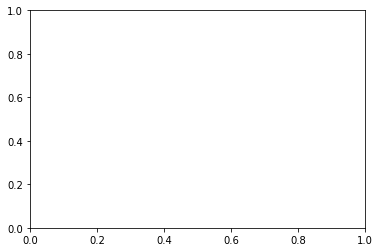

In [52]:
x = len(means)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, means)
plt.xticks(x, params)
plt.show()